<div class="alert alert-block alert-danger">
<h1>Titanic: Deep Learning from Disaster</h1>
</div>

- Goal is to predict which passengers survived the Titanic shipwreck using passenger data (ie name, age, gender, socio-economic class, etc).

<div class="alert alert-block alert-danger">
<h2>Table of Contents</h2>
</div>

[Importing Libraries](#1.0)<br>
[Loading The Data](#2.0)<br>
[Data Preprocessing](#3.0)<br>
    <ul>
        <li>[Functions to be used](#3.1)</li>
        <li>[Analyze each feature](#3.2)</li>
        <li>[Feature engineerin](#3.3)</li>
        <li>[Correlation of the features](#3.4)</li>
    </ul>
[Create A Neural Network](#4.0)<br>
    <ul>
        <li>[Building Artificial Neural Network (ANN)](#4.1)</li>
        <li>[Building Convolutional Neural Network (CNN)](#4.2)</li>
        <li>[Evaluation of the model](#4.3)</li>
    </ul>
[Submission](#5.0)<br>
    <ul>
        <li>[Results on the Kaggle website](#5.1)</li>
    </ul>

<a id='1.0'></a>
<div class="alert alert-block alert-danger">
<h2>Importing Libraries</h2>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np 
import pandas as pd
# display all of the columns
pd.set_option('display.max_columns', None)

from matplotlib import pyplot as plt
%matplotlib inline

<a id='2.0'></a>
<div class="alert alert-block alert-danger">
<h2>Loading The Data</h2>
</div>

In [2]:
train = pd.read_csv("datasets/train.csv")
train = train.drop('PassengerId', axis=1)
test = pd.read_csv("datasets/test.csv")
test = test.drop('PassengerId', axis=1)
gender_submission = pd.read_csv("datasets/gender_submission.csv")
# dependent variable
y_train = train['Survived']

In [3]:
train.tail(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [4]:
test.head(3)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


<div class="alert alert-block alert-success">
    <h4>
        Balanced or imbalanced?
    </h4>
</div>

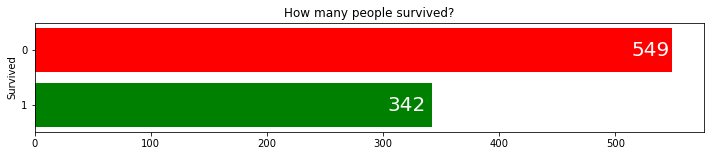

In [5]:
# The difference between positive and negative values in the dependent feature is not very high. 
# So the dataset is in balance.

fig, ax = plt.subplots(figsize = (12, 2))
# Horizontal bar chart
ax.barh(y_train.unique(), y_train.value_counts(), align='center', color=['red', 'green'])
ax.text(530, 0, y_train.value_counts()[0], ha='center', va='center', color='w', size=20)
ax.text(320, 1, y_train.value_counts()[1], ha='center', va='center', color='w', size=20)
ax.set_yticks(y_train.unique())
ax.set_yticklabels(y_train.unique())
ax.invert_yaxis()
ax.set_ylabel('Survived')
ax.set_title('How many people survived?')

plt.show()

<div class="alert alert-block alert-success">
    <h4>
        Check missing values
    </h4>
</div>

In [6]:
def get_null_count(df):
    df_null = pd.DataFrame(df.isnull().sum(), columns=['count'])
    return df_null[df_null['count']>0]

In [7]:
get_null_count(train)

,count
Age,177
Cabin,687
Embarked,2


In [8]:
get_null_count(test)

,count
Age,86
Fare,1
Cabin,327


<a id='3.0'></a>
<div class="alert alert-block alert-danger">
<h2>Data Preprocessing</h2>
</div>

<a id='3.1'></a>
<div class="alert alert-block alert-info">
   <h3>
        Functions to be used
   </h3>
</div>

<div class="alert alert-block alert-success">
    <h4>
        Visualizations
    </h4>
</div>

In [9]:
# plot a stacked bar chart to show how a feature is categorized using the independent feature
def stacked_bar_chart(df, col, target_col):
    df_group = df.groupby(col)[target_col].value_counts().sort_index(level=0).unstack()
    print(df_group)
    
    fig, ax = plt.subplots()
    width = 0.35
    
    # place the first category
    x = [str(i) for i in df_group.index]
    y = df_group[0].values
    ax.bar(x, y, width, label=df_group.columns[0])
    
    # add the second category after the previous one
    for i in range(1, len(df_group.columns)):
        z = df_group[i].values
        ax.bar(x, z, width, bottom=y, label=df_group.columns[i])
        y += z
        
    ax.set_ylabel(target_col)
    ax.set_xlabel(col)
    ax.legend()
        
    plt.show()

In [10]:
# plot a histogram chart to show a continuous dataset grouped into bins or frequencies
def hist_chart(df, num_bins):
    fig, axes = plt.subplots(figsize=(10, 5))

    sigma = df.dropna().std() # standard deviation of distribution
    mu = df.dropna().mean() # mean of distribution
    x = mu + sigma * np.random.randn(1000)
    
    # the histogram of the data
    n, bins, patches = plt.hist(df, num_bins, density=True, color='green', stacked=True, alpha=0.75)
    
    # add a 'best fit' line
    y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
        np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
    plt.plot(bins, y, '--', color ='black')

    fig.tight_layout()
    fig.show()

<img src="https://miro.medium.com/max/1400/1*2c21SkzJMf3frPXPAR_gZA.png" style="height:350px">

median (Q2/50th Percentile): the middle value of the dataset<br>
first quartile (Q1/25th Percentile): the middle number between the smallest number (not the “minimum”) and the median of the dataset.<br>
third quartile (Q3/75th Percentile): the middle value between the median and the highest value (not the “maximum”) of the dataset.<br>
interquartile range (IQR): 25th to the 75th percentile.<br>
whiskers (shown in blue)<br>
outliers (shown as green circles)<br>
“maximum”: Q3 + 1.5*IQR<br>
“minimum”: Q1 -1.5*IQR<br>

In [11]:
# plot a boxplot to show how the values in the dataset are spread out
def box_plot(df, label):
    fig, ax = plt.subplots(figsize = (10, 1))
    # rectangular box plot
    bplot = ax.boxplot(df,
                           vert=False,  # vertical box alignment
                           notch=True,  # notch shape
                           patch_artist=True,  # fill with color
                           labels=[label]  # will be used to label x-ticks
                          )
    # fill with colors
    colors = ['pink', 'lightblue', 'lightgreen']
    for box in (bplot):
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)


    whiskers_1 = bplot['whiskers'][0].get_xdata()[1]
    whiskers_2 = bplot['whiskers'][0].get_xdata()[0]
    median = bplot['medians'][0].get_xdata()[0]
    whiskers_3 = bplot['whiskers'][1].get_xdata()[0]
    whiskers_4 = bplot['whiskers'][1].get_xdata()[1]
    
    ax.text(whiskers_1, 1.15, f"{whiskers_1}", ha='center', va='center', color='b', size=13)
    ax.text(whiskers_2, 1.25, f"{whiskers_2}", ha='center', va='center', color='b', size=13)
    ax.text(median, 0.7, f"{median}", ha='center', va='center', color='b', size=13)
    ax.text(whiskers_3, 1.25, f"{whiskers_3}", ha='center', va='center', color='b', size=13)
    ax.text(whiskers_4, 1.15, f"{whiskers_4}", ha='center', va='center', color='b', size=13)

    ax.xaxis.grid(True)
    plt.show()

    outliers = bplot['fliers'][0].get_xdata()

<div class="alert alert-block alert-success">
    <h4>
        Encoding
    </h4>
</div>

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [12]:
# One Hot Encoding: Encode categorical features as a one-hot numeric array.
# find the unique values per feature and transform the data to a binary one-hot encoding
from sklearn.preprocessing import OneHotEncoder

def ohe_to_df(df_encoded, ohe_col_name, df_org, ohe_col):
    df_enc = pd.DataFrame(data=df_encoded, columns=ohe_col_name)
    
    # Some rows can be deleted since they are outliers.
    # Therefore, the index numbers are replaced with the existing dataframe
    df_enc.set_index(df_org.index, inplace=True)
    
    # drop the feature to be encoded from the main dataframe and 
    # concatenate the main dataframe with the encoded one
    df_org_dropped = df_org.drop(ohe_col, axis=1)
    df_finished = pd.concat([df_org_dropped, df_enc], axis=1)
    df_finished[ohe_col_name] = df_finished[ohe_col_name].astype(int)
    
    return df_finished
    
# One Hot Encoding the columns.
def one_hot_encoding(train, test, ohe_col):
    train_for_ohe = train[[ohe_col]]
    test_for_ohe = test[[ohe_col]]
    
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    
    # Fit OneHotEncoder to X, then transform X
    ohe.fit(train_for_ohe)
    train_encoded = ohe.transform(train_for_ohe)
    test_encoded = ohe.transform(test_for_ohe)
    
    # create feature names for the created binary columns using the feature name to be encoded and uniques
    ohe_col_name = ohe.get_feature_names([ohe_col]).tolist()
    
    df_train_encoded = ohe_to_df(train_encoded, ohe_col_name, train, ohe_col)
    df_test_encoded = ohe_to_df(test_encoded, ohe_col_name, test, ohe_col)

    return df_train_encoded, df_test_encoded

In [13]:
# Convert each value in a categorical column to a number from 0 to the number of items-1 by encoding 
def encode_categorical_column(df, col):
    # get unique values
    unique_vals = df[col].value_counts(dropna=True).index.to_list()
    
    if df[col].dtypes == 'object':
        # get a counter in the for loop and replace each unique value with the count to encode 
        for i, j in enumerate(unique_vals):
            df[col].replace(j, i, inplace=True)
    return df

<div class="alert alert-block alert-success">
    <h4>
        KBinsDiscretizer
    </h4>
</div>

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html?highlight=kbinsdiscretizer#sklearn.preprocessing.KBinsDiscretizer

- is used to convert a continuous data into categorical data.
- discretizes(split) continuous features into discrete values (k bins)

- Parameters
    - n_bins: The number of bins
    - encode: {‘onehot’, ‘onehot-dense’, ‘ordinal’}, default=’onehot’
        - ‘onehot’: one-hot encoding 
        - ‘ordinal’: encoded as an integer value
    - strategy: {‘uniform’, ‘quantile’, ‘kmeans’}, default=’quantile’
        - ‘uniform’: All bins in each feature have identical widths.
        - ‘quantile’: All bins in each feature have the same number of points.
        - ‘kmeans’: Values in each bin have the same nearest center of a 1D k-means cluster. 

In [14]:
from sklearn.preprocessing import KBinsDiscretizer

def k_bins_discretizer(df, col_kbd, n_bins, strategy):
    kbd = KBinsDiscretizer(n_bins = n_bins, encode = 'ordinal', strategy = strategy)
    df[col_kbd] = kbd.fit_transform(df[col_kbd].values.reshape(-1,1)).astype('int64')

    return df

<div class="alert alert-block alert-success">
    <h4>
        Standardization (StandardScaler)
    </h4>
</div>

- can only be done on numeric data
- does not change shape of the distribution of the feature
- simply transform(scale) the mean of that feature to be 0 and the standard deviation to be 1
- How does it work?
    - calculate the mean (Xm) and the standard deviation (Xs) for a feature X
    - for each value (Xi) in that feature X, calculate Xscaled = (Xi - Xm) / Xs
- When should be perform?
    - if in case that distances between items in an feature are quite much higher when compare to the other feature's magnitude
    - if the features have different kind of magnitudes and units 
    - only for the ML Algorithms that use the Euclidean Distance (or Manhattan ...) between two points (K-Means, K-Nearest-Neighbours, Principle Component Analysis, Gradient Descent)
    - any algorithm which is not distance based (Naive Bayes, Linear Discriminant Analysis, and Tree-Based models) is not affected by feature scaling

In [15]:
from sklearn.preprocessing import StandardScaler

def standardisation(train, test, col):
    train_for_scaler = train[[col]]
    test_for_scaler = test[[col]]
    
    scaler = StandardScaler()
    scaler.fit(train_for_scaler)
    
    # Discretize the data
    train_scaled = scaler.transform(train_for_scaler)
    test_scaled = scaler.transform(test_for_scaler)
    
    train[col] = train_scaled
    test[col] = test_scaled

    return train, test

<div class="alert alert-block alert-success">
    <h4>
        Missing value imputation
    </h4>
</div>

https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html?highlight=iterativeimputer#sklearn.impute.IterativeImputer

- Imputation is the practice of replacing missing values in data with substitute values
- multivariate imputer that estimates each feature from all the others (takes other features into account)
- can be chosen which regression model is used 
- SimpleImputer, (takes only single feature into account)
- IterativeImputer, KNNImputer

Parameters:
- estimator : estimator object, default=BayesianRidge()
- n_nearest_features: Number of other features to use to estimate the missing values of each feature column. 
- initial_strategy: default=’mean’ {“mean”, “median”, “most_frequent”, or “constant”}
- imputation_order: default=’ascending’ {“ascending”, “descending”, “roman”, “arabic”, "random"}
- max_iter default=10: Maximum number of imputation rounds to perform before returning the imputations computed during the final round. 

In [16]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

def imputing_missing_values(train, test, col_target, col_drop):
    
    df_corr = pd.DataFrame(abs(train.drop(col_drop, axis=1).corr()[col_target])).sort_values(col_target, ascending=False)
    df_corr_list = df_corr[df_corr[col_target] > 0.1].index.tolist()
    
    estimator = RandomForestRegressor(n_jobs=-1)
    imp = IterativeImputer(estimator=estimator, verbose=0, max_iter=10)
    imp.fit(train[df_corr_list])
    df_imp_train = pd.DataFrame(imp.transform(train[df_corr_list]), columns=df_corr_list)
    train[col_target] = df_imp_train[col_target]
    train[col_target] = train[col_target].astype('int64')
    
    df_imp_test = pd.DataFrame(imp.transform(test[df_corr_list]), columns=df_corr_list)
    test[col_target] = df_imp_test[col_target]
    test[col_target] = test[col_target].astype('int64')

    return train, test
# # KNNImputer

# from sklearn.impute import KNNImputer

# knn_imp = KNNImputer(n_neighbors=5)
# knn_imp.fit(train[df_age_corr_list])
# df_age_knnimp = pd.DataFrame(knn_imp.transform(train[df_age_corr_list]))
# df_age_knnimp.head()

<a id='3.2'></a>
<div class="alert alert-block alert-info">
   <h3>
        Analyze each feature
   </h3>
</div>

<div class="alert alert-block alert-success">
    <h4>
        Pclass
    </h4>
</div>

<img src="https://i.pinimg.com/originals/dd/a4/49/dda4498b1eebd33411b4b1b5b14774d6.gif" style="height:350px">

pclass: A proxy for socio-economic status (SES)<br>
Ticket class<br>
1st = First class passengers were some of the richest and most important people of the time.<br>
2nd = Many of the second class passengers were tourists, made up of professions such as teachers and clergy.<br>
3rd = The passengers in third class were mainly immigrants heading for a new life in America. <br>




Survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119


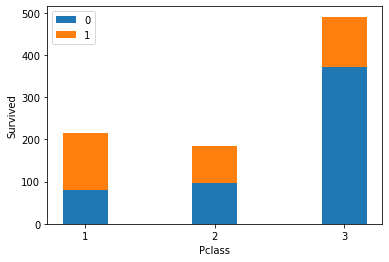

In [17]:
stacked_bar_chart(train, 'Pclass', 'Survived')

In [18]:
train.groupby(['Pclass', 'Sex', 'Survived']).count()

Name  Age  SibSp  Parch  Ticket  Fare  Cabin  Embarked
Pclass Sex    Survived                                                        
1      female 0            3    3      3      3       3     3      3         3
              1           91   82     91     91      91    91     78        89
       male   0           77   61     77     77      77    77     56        77
              1           45   40     45     45      45    45     39        45
2      female 0            6    6      6      6       6     6      1         6
              1           70   68     70     70      70    70      9        70
       male   0           91   84     91     91      91    91      2        91
              1           17   15     17     17      17    17      4        17
3      female 0           72   55     72     72      72    72      2        72
              1           72   47     72     72      72    72      4        72
       male   0          300  215    300    300     300   300      4       300
              1           47   38     47     47      47    47      2        47

In [19]:
# first class
print('If a passenger was first class and female, the chance of survival was {:.1%}.'.format(91/(3+91)))
print('If a passenger was first class and male, the chance of survival was {:.1%}.'.format(45/(77+45)))
print('=====')
# second class
print('If a passenger was second class and female, the chance of survival was {:.1%}.'.format(70/(6+70)))
print('If a passenger was second class and male, the chance of survival was {:.1%}.'.format(17/(91+17)))
print('=====')
# third class
print('If a passenger was third class and female, the chance of survival was {:.1%}.'.format(72/(72+72)))
print('If a passenger was third class and male, the chance of survival was {:.1%}.'.format(47/(300+47)))

If a passenger was first class and female, the chance of survival was 96.8%.
If a passenger was first class and male, the chance of survival was 36.9%.
=====
If a passenger was second class and female, the chance of survival was 92.1%.
If a passenger was second class and male, the chance of survival was 15.7%.
=====
If a passenger was third class and female, the chance of survival was 50.0%.
If a passenger was third class and male, the chance of survival was 13.5%.


- A person who was a 1st or 2nd class passenger and a woman was much more likely to survive on the Titanic
- Women had a higher chance of survival than men. However, the chance of survival of women in Third Class passengers were half

<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [20]:
train, test = one_hot_encoding(train, test, 'Pclass')

In [21]:
train.tail(3)

,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3
888,0,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,0,0,1
889,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,1,0,0
890,0,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,0,0,1


In [22]:
test.head(3)

,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3
0,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0,1
1,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0,1
2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,1,0


<div class="alert alert-block alert-success">
    <h4>
        Name
    </h4>
</div>

<div class="alert alert-block alert-warning">
        Extract titles
</div>

In [23]:
def group_titles(df):
    # find titles
    import re
    title = []
    for i in df['Name']:
        title.append(re.search('([A-Z][a-z]+)\.',i)[1])

    # create a column named 'Title'
    df["Title"] = title

    # the titles are grouped according to whether they survived or not.
    special_title = ['Mlle', 'Ms', 'Mme', 'Countess', 'Sir', 'Lady', 'Major', 'Col']
    ordinary_title = ['Dr', 'Rev', 'Capt', 'Don', 'Jonkheer']

    # rename each item in Title column if they are in the grouped lists above
    for ind, title in enumerate(df['Title']):
        if title in special_title:
            df.loc[ind,'Title'] = 'special'
        elif title in ordinary_title:
            df.loc[ind,'Title'] = 'ordinary'
        elif title == 'Dona':
            df.loc[ind,'Title'] = 'Mrs'
        else:
            continue
            
    return df

Survived    0    1
Title             
Master     17   23
Miss       55  127
Mr        436   81
Mrs        26   99
ordinary   13    3
special     2    9


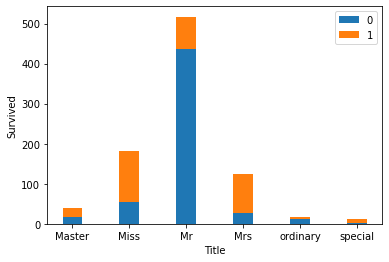

In [24]:
train = group_titles(train)
stacked_bar_chart(train, 'Title', 'Survived')

In [25]:
train.groupby(['Title', 'Survived']).count()

Name  Sex  Age  SibSp  Parch  Ticket  Fare  Cabin  \
Title    Survived                                                      
Master   0           17   17   15     17     17      17    17      0   
         1           23   23   21     23     23      23    23      7   
Miss     0           55   55   41     55     55      55    55      3   
         1          127  127  105    127    127     127   127     44   
Mr       0          436  436  331    436    436     436   436     59   
         1           81   81   67     81     81      81    81     34   
Mrs      0           26   26   23     26     26      26    26      3   
         1           99   99   85     99     99      99    99     41   
ordinary 0           13   13   12     13     13      13    13      2   
         1            3    3    3      3      3       3     3      2   
special  0            2    2    2      2      2       2     2      1   
         1            9    9    9      9      9       9     9      8   

                   Embarked  Pclass_1  Pclass_2  Pclass_3  
Title    Survived                                          
Master   0               17        17        17        17  
         1               23        23        23        23  
Miss     0               55        55        55        55  
         1              126       127       127       127  
Mr       0              436       436       436       436  
         1               81        81        81        81  
Mrs      0               26        26        26        26  
         1               98        99        99        99  
ordinary 0               13        13        13        13  
         1                3         3         3         3  
special  0                2         2         2         2  
         1                9         9         9         9

In [26]:
print('{:.1%} of Master passengers who survived.'.format(23/(17+23)))
print('{:.1%} of Miss passengers who survived.'.format(127/(55+127)))
print('{:.1%} of Mr passengers who survived.'.format(81/(436+81)))
print('{:.1%} of Mrs passengers who survived.'.format(99/(26+99)))
print('{:.1%} of Ordinary passengers who survived.'.format(3/(13+3)))
print('{:.1%} of Special passengers who survived.'.format(9/(2+9)))

57.5% of Master passengers who survived.
69.8% of Miss passengers who survived.
15.7% of Mr passengers who survived.
79.2% of Mrs passengers who survived.
18.8% of Ordinary passengers who survived.
81.8% of Special passengers who survived.


In [27]:
print('{:.1%} of the passengers who dead was Mr.'.format(436/(17+55+436+26+13+2)))

79.4% of the passengers who dead was Mr.


In [28]:
train.groupby(['Title', 'Survived']).sum()[['Pclass_1', 'Pclass_2', 'Pclass_3']].iloc[4:6,:]

Pclass_1  Pclass_2  Pclass_3
Title Survived                              
Mr    0               70        83       283
      1               37         8        36

In [29]:
print('{:.1%} of Mr passengers who died was Third Class passengers.'.format(283/(70+83+283)))

64.9% of Mr passengers who died was Third Class passengers.


In [30]:
test = group_titles(test)

<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [31]:
train, test = one_hot_encoding(train, test, 'Title')

In [32]:
train.tail(3)

,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special
888,0,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,0,0,1,0,1,0,0,0,0
889,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,1,0,0,0,0,1,0,0,0
890,0,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,0,0,1,0,0,1,0,0,0


In [33]:
test.head(3)

,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special
0,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0,1,0,0,1,0,0,0
1,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0,1,0,0,0,1,0,0
2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,1,0,0,0,1,0,0,0


<div class="alert alert-block alert-warning">
        Extract surnames
</div>

Analyze whether the people from the same family survived or died

In [34]:
import re
from sklearn.preprocessing import MinMaxScaler

def find_surnames(df):
    surname = []
    for i in df['Name']:
        surname.append(re.search('^(.+?),',i)[1])

    # create a column named 'Surname'
    df["Surname"] = surname
    df = encode_categorical_column(df, "Surname")
    
    return df
    
def find_surnames_and_normalize(train, test):
    train = find_surnames(train)
    test = find_surnames(test)

    # Normalization -> rescaling of the column to the range 0-1
    train_for_scaler = train[['Surname']]
    test_for_scaler = test[['Surname']]
    
    scaler = MinMaxScaler()
    scaler.fit(train_for_scaler)
    
    train_scaled = scaler.transform(train_for_scaler)
    test_scaled = scaler.transform(test_for_scaler)
    
    train["Surname"] = train_scaled
    test["Surname"] = test_scaled

    return train, test

In [35]:
train, test = find_surnames_and_normalize(train, test)

In [36]:
train.tail(3)

,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname
888,0,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,0,0,1,0,1,0,0,0,0,0.196697
889,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,1,0,0,0,0,1,0,0,0,0.433934
890,0,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,0,0,1,0,0,1,0,0,0,1.000000


In [37]:
test.head(3)

,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname
0,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0,1,0,0,1,0,0,0,0.294294
1,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0,1,0,0,0,1,0,0,0.466967
2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,1,0,0,0,1,0,0,0,0.381381


<div class="alert alert-block alert-warning">
        Name Type
</div>

In [38]:
def name_type(df):
    name_type = []

    for name in df['Name']:
        if ('(' in name) and (')' in name):
            name_type.append('double_name')
        else:
            name_type.append('single_name')
    # print(name_type)
    df['NameType'] = name_type
    
    return df

In [39]:
train = name_type(train)
test = name_type(test)

Survived       0    1
NameType             
double_name   33  110
single_name  516  232


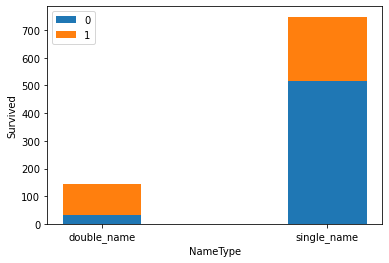

In [40]:
stacked_bar_chart(train, 'NameType', 'Survived')

In [41]:
train.groupby(['NameType', 'Survived']).count()

Name  Sex  Age  SibSp  Parch  Ticket  Fare  Cabin  \
NameType    Survived                                                      
double_name 0           33   33   28     33     33      33    33      4   
            1          110  110   96    110    110     110   110     48   
single_name 0          516  516  396    516    516     516   516     64   
            1          232  232  194    232    232     232   232     88   

                      Embarked  Pclass_1  Pclass_2  Pclass_3  Title_Master  \
NameType    Survived                                                         
double_name 0               33        33        33        33            33   
            1              109       110       110       110           110   
single_name 0              516       516       516       516           516   
            1              231       232       232       232           232   

                      Title_Miss  Title_Mr  Title_Mrs  Title_ordinary  \
NameType    Survived                                                    
double_name 0                 33        33         33              33   
            1                110       110        110             110   
single_name 0                516       516        516             516   
            1                232       232        232             232   

                      Title_special  Surname  
NameType    Survived                          
double_name 0                    33       33  
            1                   110      110  
single_name 0                   516      516  
            1                   232      232

In [42]:
print('{:.1%} of Single Name passengers who survived.'.format(232/(516+232)))
print('{:.1%} of Double Name passengers who survived.'.format(110/(33+110)))

31.0% of Single Name passengers who survived.
76.9% of Double Name passengers who survived.


In [43]:
train.groupby(['NameType', 'Sex', 'Survived']).count().iloc[:4, :]

Name  Age  SibSp  Parch  Ticket  Fare  Cabin  \
NameType    Sex    Survived                                                 
double_name female 0           28   24     28     28      28    28      3   
                   1          101   89    101    101     101   101     45   
            male   0            5    4      5      5       5     5      1   
                   1            9    7      9      9       9     9      3   

                             Embarked  Pclass_1  Pclass_2  Pclass_3  \
NameType    Sex    Survived                                           
double_name female 0               28        28        28        28   
                   1              100       101       101       101   
            male   0                5         5         5         5   
                   1                9         9         9         9   

                             Title_Master  Title_Miss  Title_Mr  Title_Mrs  \
NameType    Sex    Survived                                                  
double_name female 0                   28          28        28         28   
                   1                  101         101       101        101   
            male   0                    5           5         5          5   
                   1                    9           9         9          9   

                             Title_ordinary  Title_special  Surname  
NameType    Sex    Survived                                          
double_name female 0                     28             28       28  
                   1                    101            101      101  
            male   0                      5              5        5  
                   1                      9              9        9

- The most of Double Name passengers were women. Therefore, Double Name passengers had a higher survival rate.

<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [44]:
train, test = one_hot_encoding(train, test, 'NameType')

In [45]:
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

In [46]:
train.tail(3)

,Survived,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double_name,NameType_single_name
888,0,female,NaN,1,2,W./C. 6607,23.45,NaN,S,0,0,1,0,1,0,0,0,0,0.196697,0,1
889,1,male,26.0,0,0,111369,30.00,C148,C,1,0,0,0,0,1,0,0,0,0.433934,0,1
890,0,male,32.0,0,0,370376,7.75,NaN,Q,0,0,1,0,0,1,0,0,0,1.000000,0,1


In [47]:
test.head(3)

,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double_name,NameType_single_name
0,male,34.5,0,0,330911,7.8292,NaN,Q,0,0,1,0,0,1,0,0,0,0.294294,0,1
1,female,47.0,1,0,363272,7.0000,NaN,S,0,0,1,0,0,0,1,0,0,0.466967,1,0
2,male,62.0,0,0,240276,9.6875,NaN,Q,0,1,0,0,0,1,0,0,0,0.381381,0,1


<div class="alert alert-block alert-success">
    <h4>
        SibSp & Parch
    </h4>
</div>

SibSp: Number of siblings / spouses aboard the Titanic<br>
Parch: Number of parents / children aboard the Titanic<br>

SibSp & Parch will be evaluated together and the new feature will show us if a person is alone or has relatives. 

Survived         0      1
Family_Size              
1            374.0  163.0
2             72.0   89.0
3             43.0   59.0
4              8.0   21.0
5             12.0    3.0
6             19.0    3.0
7              8.0    4.0
8              6.0    NaN
11             7.0    NaN


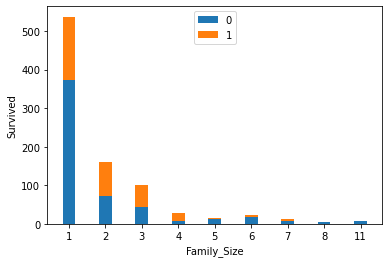

In [48]:
# including the passenger himself/herself has also been added
train['Family_Size'] = train['SibSp'] + train['Parch'] + 1

stacked_bar_chart(train, 'Family_Size', 'Survived')

In [49]:
train.groupby(['Family_Size', 'Survived']).count()

Sex  Age  SibSp  Parch  Ticket  Fare  Cabin  Embarked  \
Family_Size Survived                                                          
1           0         374  274    374    374     374   374     39       374   
            1         163  130    163    163     163   163     55       161   
2           0          72   63     72     72      72    72     17        72   
            1          89   76     89     89      89    89     49        89   
3           0          43   40     43     43      43    43      8        43   
            1          59   53     59     59      59    59     21        59   
4           0           8    6      8      8       8     8      2         8   
            1          21   21     21     21      21    21      7        21   
5           0          12    8     12     12      12    12      0        12   
            1           3    3      3      3       3     3      2         3   
6           0          19   19     19     19      19    19      2        19   
            1           3    3      3      3       3     3      2         3   
7           0           8    8      8      8       8     8      0         8   
            1           4    4      4      4       4     4      0         4   
8           0           6    6      6      6       6     6      0         6   
11          0           7    0      7      7       7     7      0         7   

                      Pclass_1  Pclass_2  Pclass_3  Title_Master  Title_Miss  \
Family_Size Survived                                                           
1           0              374       374       374           374         374   
            1              163       163       163           163         163   
2           0               72        72        72            72          72   
            1               89        89        89            89          89   
3           0               43        43        43            43          43   
            1               59        59        59            59          59   
4           0                8         8         8             8           8   
            1               21        21        21            21          21   
5           0               12        12        12            12          12   
            1                3         3         3             3           3   
6           0               19        19        19            19          19   
            1                3         3         3             3           3   
7           0                8         8         8             8           8   
            1                4         4         4             4           4   
8           0                6         6         6             6           6   
11          0                7         7         7             7           7   

                      Title_Mr  Title_Mrs  Title_ordinary  Title_special  \
Family_Size Survived                                                       
1           0              374        374             374            374   
            1              163        163             163            163   
2           0               72         72              72             72   
            1               89         89              89             89   
3           0               43         43              43             43   
            1               59         59              59             59   
4           0                8          8               8              8   
            1               21         21              21             21   
5           0               12         12              12             12   
            1                3          3               3              3   
6           0               19         19              19             19   
            1                3          3               3              3   
7           0                8          8               8              8   
            1     

In [50]:
print('{:.1%} of Family_Size=1 who survived.'.format(163/(374+163)))
print('{:.1%} of Family_Size=2 who survived.'.format(89/(72+89)))
print('{:.1%} of Family_Size=3 who survived.'.format(59/(43+59)))
print('{:.1%} of Family_Size=4 who survived.'.format(21/(8+21)))
print('{:.1%} of Family_Size more than 4 who survived.'.format((3+3+4)/(3+3+4+12+19+8+6+7)))

30.4% of Family_Size=1 who survived.
55.3% of Family_Size=2 who survived.
57.8% of Family_Size=3 who survived.
72.4% of Family_Size=4 who survived.
16.1% of Family_Size more than 4 who survived.


In [51]:
train.groupby(['Family_Size', 'Sex', 'Survived']).count().loc[:1, :]

Age  SibSp  Parch  Ticket  Fare  Cabin  Embarked  \
Family_Size Sex    Survived                                                     
1           female 0          21     27     27      27    27      2        27   
                   1          79     99     99      99    99     33        97   
            male   0         253    347    347     347   347     37       347   
                   1          51     64     64      64    64     22        64   

                             Pclass_1  Pclass_2  Pclass_3  Title_Master  \
Family_Size Sex    Survived                                               
1           female 0               27        27        27            27   
                   1               99        99        99            99   
            male   0              347       347       347           347   
                   1               64        64        64            64   

                             Title_Miss  Title_Mr  Title_Mrs  Title_ordinary  \
Family_Size Sex    Survived                                                    
1           female 0                 27        27         27              27   
                   1                 99        99         99              99   
            male   0                347       347        347             347   
                   1                 64        64         64              64   

                             Title_special  Surname  NameType_double_name  \
Family_Size Sex    Survived                                                 
1           female 0                    27       27                    27   
                   1                    99       99                    99   
            male   0                   347      347                   347   
                   1                    64       64                    64   

                             NameType_single_name  
Family_Size Sex    Survived                        
1           female 0                           27  
                   1                           99  
            male   0                          347  
                   1                           64

In [52]:
print('{:.1%} of the passengers who were alone on the ship were men. Therefore, the mortality rate in '\
      'this group is high.'.format((347+64)/(347+64+27+99)))

76.5% of the passengers who were alone on the ship were men. Therefore, the mortality rate in this group is high.


In [53]:
train.groupby(['Family_Size', 'Sex', 'Survived']).count().loc[2:4, :]

Age  SibSp  Parch  Ticket  Fare  Cabin  Embarked  \
Family_Size Sex    Survived                                                     
2           female 0          14     16     16      16    16      1        16   
                   1          58     71     71      71    71     36        71   
            male   0          49     56     56      56    56     16        56   
                   1          18     18     18      18    18     13        18   
3           female 0           9     11     11      11    11      1        11   
                   1          35     38     38      38    38     15        38   
            male   0          31     32     32      32    32      7        32   
                   1          18     21     21      21    21      6        21   
4           female 0           2      3      3       3     3      2         3   
                   1          16     16     16      16    16      3        16   
            male   0           4      5      5       5     5      0         5   
                   1           5      5      5       5     5      4         5   

                             Pclass_1  Pclass_2  Pclass_3  Title_Master  \
Family_Size Sex    Survived                                               
2           female 0               16        16        16            16   
                   1               71        71        71            71   
            male   0               56        56        56            56   
                   1               18        18        18            18   
3           female 0               11        11        11            11   
                   1               38        38        38            38   
            male   0               32        32        32            32   
                   1               21        21        21            21   
4           female 0                3         3         3             3   
                   1               16        16        16            16   
            male   0                5         5         5             5   
                   1                5         5         5             5   

                             Title_Miss  Title_Mr  Title_Mrs  Title_ordinary  \
Family_Size Sex    Survived                                                    
2           female 0                 16        16         16              16   
                   1                 71        71         71              71   
            male   0                 56        56         56              56   
                   1                 18        18         18              18   
3           female 0                 11        11         11              11   
                   1                 38        38         38              38   
            male   0                 32        32         32              32   
                   1                 21        21         21              21   
4           female 0                  3         3          3               3   
                   1                 16        16         16              16   
            male   0                  5         5          5               5   
                   1                  5         5          5               5   

                             Title_special  Surname  NameType_double_name  \
Family_Size Sex    Survived                                                 
2           female 0                    16       16                    16   
                   1                    71       71                    71   
            male   0                    56       56                    56   
                   1                    18       18                    18   
3           female 0                    11       11                    11   
                   1                    38       38                    38   
            male   0                    32       32                    32   
                   1         

- In families with 2, 3 and 4 people, men preferred to sacrifice themselves for their families

In [54]:
train.groupby(['Family_Size']).sum().loc[:, ['Pclass_1', 'Pclass_2', 'Pclass_3']].loc[5:, :]

,Pclass_1,Pclass_2,Pclass_3
Family_Size,,,
5,2,1,12
6,4,1,17
7,0,0,12
8,0,0,6
11,0,0,7


- Families with more than 4 people were less likely to survive as they mostly had 3rd class tickets.

In [55]:
# group sizes larger than 4
for ind, size in enumerate(train['Family_Size']):
    if size > 4:
        train.loc[ind, 'Family_Size'] = 5

In [56]:
# including the passenger himself/herself has also been added
test['Family_Size'] = test['SibSp'] + test['Parch'] + 1

# group sizes larger than 4
for ind, size in enumerate(test['Family_Size']):
    if size > 4:
        test.loc[ind, 'Family_Size'] = 5

<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [57]:
train, test = one_hot_encoding(train, test, 'Family_Size')
train, test = one_hot_encoding(train, test, 'SibSp')
train, test = one_hot_encoding(train, test, 'Parch')

In [58]:
train.tail(3)

,Survived,Sex,Age,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double_name,NameType_single_name,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
888,0,female,NaN,W./C. 6607,23.45,NaN,S,0,0,1,0,1,0,0,0,0,0.196697,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
889,1,male,26.0,111369,30.00,C148,C,1,0,0,0,0,1,0,0,0,0.433934,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
890,0,male,32.0,370376,7.75,NaN,Q,0,0,1,0,0,1,0,0,0,1.000000,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [59]:
test.head(3)

,Sex,Age,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double_name,NameType_single_name,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,male,34.5,330911,7.8292,NaN,Q,0,0,1,0,0,1,0,0,0,0.294294,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,female,47.0,363272,7.0000,NaN,S,0,0,1,0,0,0,1,0,0,0.466967,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,male,62.0,240276,9.6875,NaN,Q,0,1,0,0,0,1,0,0,0,0.381381,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


<div class="alert alert-block alert-success">
    <h4>
        Ticket
    </h4>
</div>

<img src="https://i.pinimg.com/564x/f0/e3/7e/f0e37e285cb14ecd3ea426c061db9aa3.jpg" style="height:200px">

In [60]:
def ticket_number_info(df, col):
    ticket_type = []
    ticket_num_len = []
    for i in df[col]:
        # split letters and numbers from ticket number
        splitted = i.split(' ')
        # if the ticket number does not have any letter, fill as 'no_type'
        if len(splitted)==1:
            ticket_type.append('no_type')
            ticket_num_len.append(len(splitted[0].strip()))
        elif len(splitted)==2:
            ticket_type.append(splitted[0].strip())
            ticket_num_len.append(len(splitted[1]))
        elif len(splitted)==3:
            ticket_type.append((''.join(splitted[0:2]).strip()))
            ticket_num_len.append(len(splitted[2].strip()))
        else:
            print(i)
    # create new columns named 'Ticket_type' and 'Ticket_num_len'
    df['Ticket_type'] = ticket_type
    df['Ticket_num_len'] = ticket_num_len

    # change the item to 3 if the ticket number length is less than 4
    for ind, num in enumerate(df['Ticket_num_len']):
        if num < 4:
            df.loc[ind, 'Ticket_num_len'] = 3
            
    return df

In [61]:
train = ticket_number_info(train, 'Ticket')

Survived          0    1
Ticket_num_len          
3                 6    3
4               116   53
5               107  139
6               288  135
7                32   12


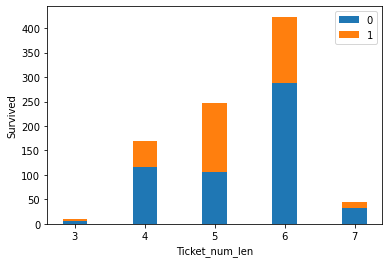

In [62]:
stacked_bar_chart(train, 'Ticket_num_len', 'Survived')

<div class="alert alert-block alert-warning">
        Encoding & KBinsDiscretizer
</div>

Survived       0    1
Ticket_type          
0            530  333
1             19    9


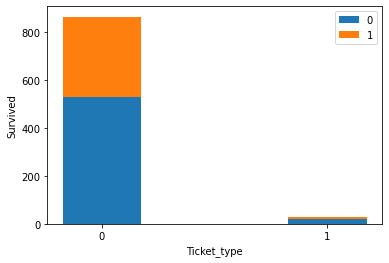

In [63]:
encode_categorical_column(train, 'Ticket_type')
train = k_bins_discretizer(train, 'Ticket_type', 2, 'uniform')
stacked_bar_chart(train, 'Ticket_type', 'Survived')

In [64]:
test = ticket_number_info(test, 'Ticket')
encode_categorical_column(test, 'Ticket_type')
test = k_bins_discretizer(test, 'Ticket_type', 2, 'uniform')

<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [65]:
train, test = one_hot_encoding(train, test, 'Ticket_num_len')
train, test = one_hot_encoding(train, test, 'Ticket_type')
train.drop('Ticket', axis=1, inplace=True)
test.drop('Ticket', axis=1, inplace=True)

In [66]:
train.tail(3)

,Survived,Sex,Age,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double_name,NameType_single_name,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1
888,0,female,NaN,23.45,NaN,S,0,0,1,0,1,0,0,0,0,0.196697,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
889,1,male,26.0,30.00,C148,C,1,0,0,0,0,1,0,0,0,0.433934,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
890,0,male,32.0,7.75,NaN,Q,0,0,1,0,0,1,0,0,0,1.000000,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0


In [67]:
test.head(3)

,Sex,Age,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double_name,NameType_single_name,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1
0,male,34.5,7.8292,NaN,Q,0,0,1,0,0,1,0,0,0,0.294294,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
1,female,47.0,7.0000,NaN,S,0,0,1,0,0,0,1,0,0,0.466967,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
2,male,62.0,9.6875,NaN,Q,0,1,0,0,0,1,0,0,0,0.381381,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0


<div class="alert alert-block alert-success">
    <h4>
        Cabin
    </h4>
</div>

In [68]:
import re

def extract_cabin_class(df, col):
    cabin_class = []
    for i in df[col]:
        if i != 'unknown':
            # get the first letter of the Cabin Number
            cabin_class.append(re.search('^(\w)',i)[1])
        else:
            # if the Cabin Number is unknown, fill as 'U'
            cabin_class.append('U')
            
    # create a column named 'Cabin_class'
    df["Cabin_class"] = cabin_class
    df.drop(['Cabin'], axis=1, inplace=True)
    
    return df

In [69]:
train['Cabin'].fillna('unknown', inplace=True)
train = extract_cabin_class(train, 'Cabin')

Survived         0      1
Cabin_class              
A              8.0    7.0
B             12.0   35.0
C             24.0   35.0
D              8.0   25.0
E              8.0   24.0
F              5.0    8.0
G              2.0    2.0
T              1.0    NaN
U            481.0  206.0


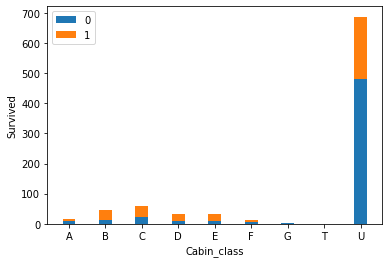

In [70]:
stacked_bar_chart(train, 'Cabin_class', 'Survived')

- A, B Deck, also called the Promenade Deck, It was reserved exclusively for First Class passengers
- C, D Deck, the Saloon Deck, First, Second and Third Class passengers had cabins on this deck
- E Deck, the Upper Deck, was predominantly used for passenger accommodation for all three classes
- F Deck, the Middle Deck, mainly accommodated Second and Third Class passengers and several departments of the crew.
- G Deck, the Lower Deck, was the lowest complete deck that carried passengers, and had the lowest portholes, just above the waterline. 

In [71]:
train.groupby(['Cabin_class', 'Survived']).sum().loc['U', ['Pclass_1', 'Pclass_2', 'Pclass_3']]

,Pclass_1,Pclass_2,Pclass_3
Survived,,,
0,21,94,366
1,19,74,113


In [72]:
print('{:.1%} of the passengers whose cabin classes were unknown and who died were Third Class passengers.' \
      'Of course, most of them were men.'.format((366)/(21+94+366)))

76.1% of the passengers whose cabin classes were unknown and who died were Third Class passengers.Of course, most of them were men.


In [73]:
test['Cabin'].fillna('unknown', inplace=True)
test = extract_cabin_class(test, 'Cabin')

<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [74]:
train, test = one_hot_encoding(train, test, 'Cabin_class')

In [75]:
train.tail(3)

,Survived,Sex,Age,Fare,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double_name,NameType_single_name,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_U
888,0,female,NaN,23.45,S,0,0,1,0,1,0,0,0,0,0.196697,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
889,1,male,26.0,30.00,C,1,0,0,0,0,1,0,0,0,0.433934,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
890,0,male,32.0,7.75,Q,0,0,1,0,0,1,0,0,0,1.000000,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1


In [76]:
test.head(3)

,Sex,Age,Fare,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double_name,NameType_single_name,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_U
0,male,34.5,7.8292,Q,0,0,1,0,0,1,0,0,0,0.294294,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
1,female,47.0,7.0000,S,0,0,1,0,0,0,1,0,0,0.466967,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
2,male,62.0,9.6875,Q,0,1,0,0,0,1,0,0,0,0.381381,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1


<div class="alert alert-block alert-success">
    <h4>
        Sex
    </h4>
</div>

Survived    0    1
Sex               
female     81  233
male      468  109


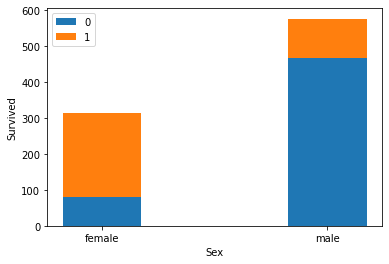

In [77]:
stacked_bar_chart(train, 'Sex', 'Survived')

In [78]:
train.groupby(['Sex', 'Survived']).count()

Age  Fare  Embarked  Pclass_1  Pclass_2  Pclass_3  \
Sex    Survived                                                      
female 0          64    81        81        81        81        81   
       1         197   233       231       233       233       233   
male   0         360   468       468       468       468       468   
       1          93   109       109       109       109       109   

                 Title_Master  Title_Miss  Title_Mr  Title_Mrs  \
Sex    Survived                                                  
female 0                   81          81        81         81   
       1                  233         233       233        233   
male   0                  468         468       468        468   
       1                  109         109       109        109   

                 Title_ordinary  Title_special  Surname  NameType_double_name  \
Sex    Survived                                                                 
female 0                     81             81       81                    81   
       1                    233            233      233                   233   
male   0                    468            468      468                   468   
       1                    109            109      109                   109   

                 NameType_single_name  Family_Size_1  Family_Size_2  \
Sex    Survived                                                       
female 0                           81             81             81   
       1                          233            233            233   
male   0                          468            468            468   
       1                          109            109            109   

                 Family_Size_3  Family_Size_4  Family_Size_5  SibSp_0  \
Sex    Survived                                                         
female 0                    81             81             81       81   
       1                   233            233            233      233   
male   0                   468            468            468      468   
       1                   109            109            109      109   

                 SibSp_1  SibSp_2  SibSp_3  SibSp_4  SibSp_5  SibSp_8  \
Sex    Survived                                                         
female 0              81       81       81       81       81       81   
       1             233      233      233      233      233      233   
male   0             468      468      468      468      468      468   
       1             109      109      109      109      109      109   

                 Parch_0  Parch_1  Parch_2  Parch_3  Parch_4  Parch_5  \
Sex    Survived                                                         
female 0              81       81       81       81       81       81   
       1             233      233      233      233      233      233   
male   0             468      468      468      468      468      468   
       1             109      109      109      109      109      109   

                 Parch_6  Ticket_num_len_3  Ticket_num_len_4  \
Sex    Survived                                                
female 0              81                81                81   
       1             233               233               233   
male   0             468               468               468   
       1             109               109               109   

                 Ticket_num_len_5  Ticket_num_len_6  Ticket_num_len_7  \
Sex    Survived                                                         
female 0                       81                81                81   
       1                      233               233               233   
male   0                      468               468               468   
       1                      109               109               109   

                 Ticket_type_0  Ticket_type_1  Cabin_class_A  Cabin_class_B  \
Sex    Survived                                                  

In [79]:
print('{:.1%} of male passengers who survived.'.format((109)/(468+109)))
print('{:.1%} of female passengers who survived.'.format((233)/(81+233)))

18.9% of male passengers who survived.
74.2% of female passengers who survived.


In [80]:
train.groupby(['Sex', 'Survived']).sum().loc['male', ['Pclass_1', 'Pclass_2', 'Pclass_3']]

,Pclass_1,Pclass_2,Pclass_3
Survived,,,
0,77,91,300
1,45,17,47


In [81]:
print('{:.1%} of male passengers who died were Third Class passengers.'.format(300/(77+91+300)))

64.1% of male passengers who died were Third Class passengers.


<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [82]:
train, test = one_hot_encoding(train, test, 'Sex')

In [83]:
train.tail(3)

,Survived,Age,Fare,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double_name,NameType_single_name,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_U,Sex_female,Sex_male
888,0,NaN,23.45,S,0,0,1,0,1,0,0,0,0,0.196697,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
889,1,26.0,30.00,C,1,0,0,0,0,1,0,0,0,0.433934,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1
890,0,32.0,7.75,Q,0,0,1,0,0,1,0,0,0,1.000000,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1


In [84]:
test.head(3)

,Age,Fare,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double_name,NameType_single_name,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_U,Sex_female,Sex_male
0,34.5,7.8292,Q,0,0,1,0,0,1,0,0,0,0.294294,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1
1,47.0,7.0000,S,0,0,1,0,0,0,1,0,0,0.466967,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0
2,62.0,9.6875,Q,0,1,0,0,0,1,0,0,0,0.381381,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1


<div class="alert alert-block alert-success">
    <h4>
        Embarked
    </h4>
</div>

Port of Embarkation<br>
C = Cherbourg, Q = Queenstown, S = Southampton

In [85]:
train[train['Embarked'].isna()]

,Survived,Age,Fare,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double_name,NameType_single_name,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_U,Sex_female,Sex_male
61,1,38.0,80.0,NaN,1,0,0,0,1,0,0,0,0,0.753754,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
829,1,62.0,80.0,NaN,1,0,0,0,0,0,1,0,0,0.381381,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0


<div class="alert alert-block alert-warning">
        Missing Values
</div>

In [86]:
# train[(train['Cabin_class']=='B') & (train['Fare_cat']==5) & (train['Ticket_num_len']==6) & (train['Family_Size']==0)]
train[(train['Survived']==1) & (train['Family_Size_1']==1) & (train['Cabin_class_B']==1) & 
      (train['Sex_female']==1) & (train['Ticket_num_len_5']==0) & (train['Ticket_num_len_6']==1)]

,Survived,Age,Fare,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double_name,NameType_single_name,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_U,Sex_female,Sex_male
61,1,38.0,80.0,NaN,1,0,0,0,1,0,0,0,0,0.753754,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
257,1,30.0,86.5,S,1,0,0,0,1,0,0,0,0,0.929429,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
504,1,16.0,86.5,S,1,0,0,0,1,0,0,0,0,0.324324,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
759,1,33.0,86.5,S,1,0,0,0,0,0,0,0,1,0.546547,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
829,1,62.0,80.0,NaN,1,0,0,0,0,0,1,0,0,0.381381,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
887,1,19.0,30.0,S,1,0,0,0,1,0,0,0,0,0.058559,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0


In [87]:
for ind in train[train['Embarked'].isna()].index:
    train.loc[ind, 'Embarked'] = 'S'

Survived    0    1
Embarked          
C          75   93
Q          47   30
S         427  219


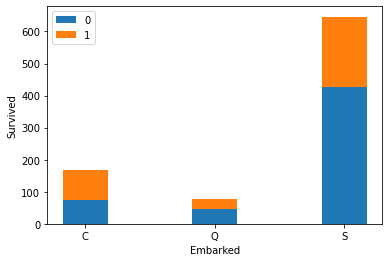

In [88]:
stacked_bar_chart(train, 'Embarked', 'Survived')

In [89]:
train.groupby(['Embarked', 'Survived']).count()

Age  Fare  Pclass_1  Pclass_2  Pclass_3  Title_Master  \
Embarked Survived                                                          
C        0          51    75        75        75        75            75   
         1          79    93        93        93        93            93   
Q        0          20    47        47        47        47            47   
         1           8    30        30        30        30            30   
S        0         353   427       427       427       427           427   
         1         203   219       219       219       219           219   

                   Title_Miss  Title_Mr  Title_Mrs  Title_ordinary  \
Embarked Survived                                                    
C        0                 75        75         75              75   
         1                 93        93         93              93   
Q        0                 47        47         47              47   
         1                 30        30         30              30   
S        0                427       427        427             427   
         1                219       219        219             219   

                   Title_special  Surname  NameType_double_name  \
Embarked Survived                                                 
C        0                    75       75                    75   
         1                    93       93                    93   
Q        0                    47       47                    47   
         1                    30       30                    30   
S        0                   427      427                   427   
         1                   219      219                   219   

                   NameType_single_name  Family_Size_1  Family_Size_2  \
Embarked Survived                                                       
C        0                           75             75             75   
         1                           93             93             93   
Q        0                           47             47             47   
         1                           30             30             30   
S        0                          427            427            427   
         1                          219            219            219   

                   Family_Size_3  Family_Size_4  Family_Size_5  SibSp_0  \
Embarked Survived                                                         
C        0                    75             75             75       75   
         1                    93             93             93       93   
Q        0                    47             47             47       47   
         1                    30             30             30       30   
S        0                   427            427            427      427   
         1                   219            219            219      219   

                   SibSp_1  SibSp_2  SibSp_3  SibSp_4  SibSp_5  SibSp_8  \
Embarked Survived                                                         
C        0              75       75       75       75       75       75   
         1              93       93       93       93       93       93   
Q        0              47       47       47       47       47       47   
         1              30       30       30       30       30       30   
S        0             427      427      427      427      427      427   
         1             219      219      219      219      219      219   

                   Parch_0  Parch_1  Parch_2  Parch_3  Parch_4  Parch_5  \
Embarked Survived                                                         
C        0              75       75       75       75       75       75   
         1              93       93       93       93       93       93   
Q        0              47       47       47       47       47       47   
         1              30       30       30       30       30       30   
S        0             427      427      427      427      427      427   


In [90]:
print('{:.1%} of passengers boarded the Titanic in the Port of Cherbourg.'.format((75+93)/len(train)))
print('{:.1%} of passengers boarded the Titanic in the Port of Queenstown.'.format((47+30)/len(train)))
print('{:.1%} of passengers boarded the Titanic in the Port of Southampton.'.format((427+219)/len(train)))

18.9% of passengers boarded the Titanic in the Port of Cherbourg.
8.6% of passengers boarded the Titanic in the Port of Queenstown.
72.5% of passengers boarded the Titanic in the Port of Southampton.


In [91]:
train.groupby(['Embarked', 'Survived']).sum().loc[:, ['Pclass_1', 'Pclass_2', 'Pclass_3']]

Pclass_1  Pclass_2  Pclass_3
Embarked Survived                              
C        0               26         8        41
         1               59         9        25
Q        0                1         1        45
         1                1         2        27
S        0               53        88       286
         1               76        76        67

In [92]:
# from the Port of Cherbourg
print('{:.1%} of passengers had 1.st or 2.nd Class Ticket.'.format((26+8+59+9)/(26+8+59+9+41+25)))
print('=====')
# from the Port of Queenstown
print('{:.1%} of passengers had 3.st Class Ticket.'.format((45+27)/(1+1+1+2+45+27)))
print('=====')
# from the Port of Southampton
print('{:.1%} of passengers had 3.st Class Ticket.'.format((286+67)/(53+88+76+76+286+67)))

60.7% of passengers had 1.st or 2.nd Class Ticket.
=====
93.5% of passengers had 3.st Class Ticket.
=====
54.6% of passengers had 3.st Class Ticket.


- These rates give us information about the economic conditions in the cities.

<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [93]:
train, test = one_hot_encoding(train, test, 'Embarked')

In [94]:
train.tail(3)

,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double_name,NameType_single_name,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_U,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
888,0,NaN,23.45,0,0,1,0,1,0,0,0,0,0.196697,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1
889,1,26.0,30.00,1,0,0,0,0,1,0,0,0,0.433934,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0
890,0,32.0,7.75,0,0,1,0,0,1,0,0,0,1.000000,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0


In [95]:
test.head(3)

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double_name,NameType_single_name,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_U,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,34.5,7.8292,0,0,1,0,0,1,0,0,0,0.294294,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
1,47.0,7.0000,0,0,1,0,0,0,1,0,0,0.466967,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1
2,62.0,9.6875,0,1,0,0,0,1,0,0,0,0.381381,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0


<div class="alert alert-block alert-success">
    <h4>
        Age
    </h4>
</div>

<div class="alert alert-block alert-warning">
        Missing Values
</div>

In [96]:
train, test = imputing_missing_values(train, test, 'Age',  ['Survived', 'Fare'])

<div class="alert alert-block alert-warning">
        Drop Outliers
</div>

In [97]:
test['Age'].max()

76

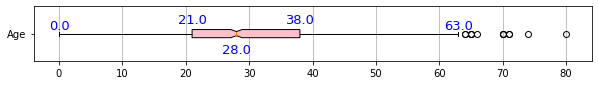

In [98]:
box_plot(train['Age'], 'Age')

In [99]:
outliers_index_age = train[train['Age'] > 76].index
print(outliers_index_age)

Int64Index([630], dtype='int64')


In [100]:
train = train.drop(outliers_index_age, axis=0).reset_index(drop=True)
y_train = y_train.drop(outliers_index_age, axis=0).reset_index(drop=True)

<div class="alert alert-block alert-warning">
        Standardisation
</div>

In [101]:
train, test = standardisation(train, test, 'Age')

In [102]:
train.head(3)

,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double_name,NameType_single_name,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_U,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,-0.546782,7.2500,0,0,1,0,0,1,0,0,0,0.147147,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
1,1,0.621436,71.2833,1,0,0,0,0,0,1,0,0,0.807808,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
2,1,-0.254727,7.9250,0,0,1,0,1,0,0,0,0,0.735736,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1


In [103]:
test.head(3)

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double_name,NameType_single_name,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_U,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.329382,7.8292,0,0,1,0,0,1,0,0,0,0.294294,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
1,1.278559,7.0000,0,0,1,0,0,0,1,0,0,0.466967,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1
2,2.373763,9.6875,0,1,0,0,0,1,0,0,0,0.381381,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0


<div class="alert alert-block alert-success">
    <h4>
        Fare
    </h4>
</div>

<div class="alert alert-block alert-warning">
        Missing Values
</div>

In [104]:
train, test = imputing_missing_values(train, test, 'Fare',  ['Survived', 'Age'])

<div class="alert alert-block alert-warning">
        Drop Outliers
</div>

In [105]:
test['Fare'].max()

512

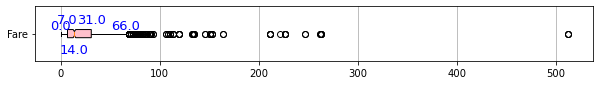

In [106]:
box_plot(train['Fare'], 'Fare')

In [107]:
outliers_index_age = train[train['Fare'] > test['Fare'].max()].index
print(outliers_index_age)

Int64Index([], dtype='int64')


<div class="alert alert-block alert-warning">
        Standardisation
</div>

In [108]:
rain, test = standardisation(train, test, 'Fare')

In [109]:
train.tail(3)

,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double_name,NameType_single_name,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_U,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
887,0,-1.495959,-0.176801,0,0,1,0,1,0,0,0,0,0.196697,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1
888,1,-0.254727,-0.035966,1,0,0,0,0,1,0,0,0,0.433934,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0
889,0,0.183354,-0.498708,0,0,1,0,0,1,0,0,0,1.000000,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0


In [110]:
test.head(3)

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double_name,NameType_single_name,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_U,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.329382,-0.498708,0,0,1,0,0,1,0,0,0,0.294294,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
1,1.278559,-0.498708,0,0,1,0,0,0,1,0,0,0.466967,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1
2,2.373763,-0.458470,0,1,0,0,0,1,0,0,0,0.381381,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0


<a id='3.3'></a>
<div class="alert alert-block alert-info">
   <h3>
        Feature engineering
   </h3>
</div>

In [111]:
X_train = train.drop(['Survived'], axis=1)
X_test = test

print(X_train.shape)
print(X_test.shape)

(890, 54)
(418, 54)


<div class="alert alert-block alert-success">
    <h4>
        Check categorical columns
    </h4>
</div>

In [112]:
categorical_feature_cols = list(set(X_train.columns) - set(X_train._get_numeric_data().columns))
categorical_feature_cols

[]

- There is no categorical columns in the dataframe

In [113]:
numerical_feature_cols = list(X_train._get_numeric_data().columns)
print(numerical_feature_cols)

['Age', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_ordinary', 'Title_special', 'Surname', 'NameType_double_name', 'NameType_single_name', 'Family_Size_1', 'Family_Size_2', 'Family_Size_3', 'Family_Size_4', 'Family_Size_5', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6', 'Ticket_num_len_3', 'Ticket_num_len_4', 'Ticket_num_len_5', 'Ticket_num_len_6', 'Ticket_num_len_7', 'Ticket_type_0', 'Ticket_type_1', 'Cabin_class_A', 'Cabin_class_B', 'Cabin_class_C', 'Cabin_class_D', 'Cabin_class_E', 'Cabin_class_F', 'Cabin_class_G', 'Cabin_class_T', 'Cabin_class_U', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']


<div class="alert alert-block alert-success">
    <h4>
        Constant and quasi constant features removal
    </h4>
</div>

- Constant: remove the features that have the same value in all samples
- Quasi constant : remove the features that they have the 99% same value 

In [114]:
# Constant
from sklearn.feature_selection import VarianceThreshold
constant=VarianceThreshold(threshold=0)
constant.fit(X_train)

constant_columns = [column for column in X_train.columns
                    if column not in X_train.columns[constant.get_support()]]
print(len(constant_columns))

0


In [115]:
# Quasi constant
from sklearn.feature_selection import VarianceThreshold
quasi_constant=VarianceThreshold(threshold=0.01)
quasi_constant.fit(X_train)

quasi_constant_columns = [column for column in X_train.columns
                    if column not in X_train.columns[quasi_constant.get_support()]]
print(quasi_constant_columns)

['SibSp_5', 'SibSp_8', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6', 'Cabin_class_G', 'Cabin_class_T']


In [116]:
X_train = pd.DataFrame(quasi_constant.transform(X_train), columns=X_train.columns[quasi_constant.get_support()])
X_test = pd.DataFrame(quasi_constant.transform(X_test), columns=X_test.columns[quasi_constant.get_support()])

In [117]:
X_train.shape, X_test.shape

((890, 46), (418, 46))

<div class="alert alert-block alert-success">
    <h4>
        Remove duplicate features
    </h4>
</div>

In [118]:
X_train_T = X_train.T
X_test_T = X_test.T

In [119]:
X_train_T.duplicated().sum()

0

- There are no dublicated features

In [120]:
# features_to_keep = [not ind for ind  in X_train_T.duplicated()]
# X_train = X_train_T[features_to_keep].T
# X_test = X_test_T[features_to_keep].T

<div class="alert alert-block alert-success">
    <h4>
        Drop highly correlated features using Pearson Correlation
    </h4>
</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/3/34/Correlation_coefficient.png" style="height:250px">

Pearson correlation coefficient
- a measure of linear correlation between features
- the measure can only reflect a linear correlation of variables, and ignores many other types of relationship or correlation
- the result always has a value between −1 and 1

In [121]:
def highly_correlated_features(df, threshold):
    corr_matrix = df.corr()
    
    df_corr_list = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                ind_name = corr_matrix.columns[i]
                col_name = corr_matrix.columns[j]
                coeff_value_absolute = abs(corr_matrix.iloc[i, j])
                df_corr_list.append([ind_name, col_name, coeff_value_absolute])
                
    df_corr = pd.DataFrame(df_corr_list, columns=['Feature_1', 'Feature_2', 'Corr_value'])
    
    return df_corr
        
df_hcf = highly_correlated_features(train, 0.85)
df_hcf = df_hcf.sort_values(by=['Feature_1', 'Feature_2', 'Corr_value'], ascending=False)
df_hcf

,Feature_1,Feature_2,Corr_value
3,Ticket_type_1,Ticket_type_0,1.000000
5,Sex_male,Title_Mr,0.867247
6,Sex_male,Sex_female,1.000000
4,Sex_female,Title_Mr,0.867247
1,NameType_single_name,Title_Mrs,0.888658
2,NameType_single_name,NameType_double_name,1.000000
0,NameType_double_name,Title_Mrs,0.888658


<div class="alert alert-block alert-success">
    <h4>
        Feature importance based on RandomForestClassifier
    </h4>
</div>

- create correlated feature groups using the highly_correlated_features dataframe (df_hcf)
- only one feature will be selected from each group using RandomForestClassifier
- other features in each group will be removed

In [122]:
from sklearn.ensemble import RandomForestClassifier

# the list is used to check if each feature is in previous groups
grouped_feature_list = []
# the items in the list will be removed from the X_train and X_test
dropped_feature_list = []

for feature in df_hcf['Feature_1'].unique():
    if feature not in grouped_feature_list:
        # group the highly_correlated_features dataframe (df_hcf)
        df_feature = df_hcf[df_hcf['Feature_1'] == feature]        
        
        correlated_features_list = [feature] + list(df_feature['Feature_2'].unique())
        grouped_feature_list = grouped_feature_list + correlated_features_list

        rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
        rf.fit(train[correlated_features_list], y_train)
        # create an importance dataframe using the feature_importances_ values
        df_importance = pd.concat([pd.Series(correlated_features_list), pd.Series(rf.feature_importances_)], 
                               axis=1)
        df_importance.columns = ['Feature', 'Importance']
        df_importance.sort_values(by = 'Importance', ascending=False, inplace=True)
        # get the feature names except the one that has the highest improtance from the df_importance
        dropped_feature_list = dropped_feature_list + list(df_importance['Feature'][1:].values)
    
print(dropped_feature_list)  


['Ticket_type_1', 'Sex_male', 'Sex_female', 'NameType_single_name', 'NameType_double_name']


In [123]:
# drop the highly correlated features 
X_train = X_train.drop(dropped_feature_list, axis=1)
X_test = X_test.drop(dropped_feature_list, axis=1)

print(X_train.shape)
print(X_test.shape)

(890, 41)
(418, 41)


<div class="alert alert-block alert-success">
    <h4>
        SelectFromModel using Logistic Regression
    </h4>
</div>

In [124]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def feature_selection(model, X_train, y_train):
    cv = KFold(n_splits=10, random_state=0, shuffle=True)
    cvs = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    acc = cvs.mean()
    
    return acc

SelectFromModel<br>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html?highlight=selectfrommodel#sklearn.feature_selection.SelectFromModel
- SelectFromModel can be used alongside any estimator that assigns importance to each feature through a specific attribute (such as coef_, feature_importances_). 

Parameters
- estimator: The estimator should have a feature_importances_ or coef_ attribute after fitting. Otherwise, the importance_getter parameter should be used
- threshold: “mean” is used by default

In [125]:
from sklearn.feature_selection import SelectFromModel as SFM
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(n_jobs=-1)
sfm = SFM(model).fit(X_train, y_train)
cols_SFM = X_train.columns[sfm.get_support()].tolist()
print(cols_SFM)

acc = feature_selection(model, X_train, y_train)
acc_SFM = feature_selection(model, X_train[cols_SFM], y_train)

print('The Accuracy all features: {:.1%}'.format(acc))
print('The Accuracy selected features with SFM: {:.1%}'.format(acc_SFM))

['Age', 'Pclass_1', 'Pclass_3', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_ordinary', 'Surname', 'Family_Size_4', 'Family_Size_5', 'SibSp_2', 'Ticket_num_len_7', 'Cabin_class_D', 'Cabin_class_E', 'Cabin_class_U']
The Accuracy all features: 83.5%
The Accuracy selected features with SFM: 83.7%


<div class="alert alert-block alert-success">
    <h4>
        GenericUnivariateSelect and ANOVA F-value
    </h4>
</div>

In [126]:
from sklearn.feature_selection import SelectFromModel as SFM
from sklearn.linear_model import LogisticRegression

def best_features (model, X_train, y_train, cols_sel, cols_SFM, acc, acc_SFM):
    cols_model_best = []
    acc_model_best = 0
    for col in cols_sel:
        if col not in cols_SFM:
            cols_SFM = cols_SFM + [col]
            cv = KFold(n_splits=10, random_state=0, shuffle=True)
            cvs_model = cross_val_score(model, X_train[cols_SFM], y_train, scoring='accuracy', cv=cv)
            acc_model = cvs_model.mean()
            if (acc_model > acc_SFM) & (acc_model > acc_model_best):
                cols_model_best = cols_SFM
                acc_model_best = acc_model
                print(cols_model_best)
                print('The Accuracy all features: {:.1%}'.format(acc))
                print('The Accuracy selected features with SFM: {:.1%}'.format(acc_SFM))
                print('The Accuracy selected features with MODEL: {:.1%}'.format(acc_model_best))
                print('=====')

GenericUnivariateSelect<br>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.GenericUnivariateSelect.html
- Univariate feature selection works by selecting the best features based on univariate statistical tests. 
- GenericUnivariateSelect allows to perform univariate feature selection with a configurable strategy. This allows to select the best univariate selection strategy with hyper-parameter search estimator.

Parameters

- score_func, default=f_classif
- mode: Feature selection mode {‘percentile’, ‘k_best’, ‘fpr’, ‘fdr’, ‘fwe’}, default=’percentile’
- param: Parameter of the corresponding mode

In [127]:
from sklearn.feature_selection import GenericUnivariateSelect as GUS
# ANOVA F-value between label/feature for classification tasks.
from sklearn.feature_selection import f_classif

gus_f = GUS(f_classif, mode='k_best', param=len(X_train.columns)).fit(X_train, y_train)
cols_gus_f = X_train.columns[gus_f.get_support()].tolist()

best_features(model, X_train, y_train, cols_gus_f, cols_SFM, acc, acc_SFM)

<div class="alert alert-block alert-success">
    <h4>
        SelectKBest and Mutual Information
    </h4>
</div>

SelectKBest<br>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html?highlight=selectkbest#sklearn.feature_selection.SelectKBest
- Univariate feature selection works by selecting the best features based on univariate statistical tests. 
- SelectKBest removes all but the  highest scoring features

Parameters

- score_func, default=f_classif
- k, default=10: Number of top features to select

In [128]:
from sklearn.feature_selection import SelectKBest
# Mutual information for a discrete target.
from sklearn.feature_selection import mutual_info_classif

# select the  top k important features
KBest_m = SelectKBest(mutual_info_classif, k=len(X_train.columns)).fit(X_train, y_train)
cols_KBest_m = X_train.columns[KBest_m.get_support()].tolist()

best_features(model, X_train, y_train, cols_KBest_m, cols_SFM, acc, acc_SFM)

<div class="alert alert-block alert-success">
    <h4>
        RFE (Recursive feature elimination)
    </h4>
</div>

RFE<br>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html?highlight=rfe#sklearn.feature_selection.RFE
- Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features.

Parameters

- estimator: A supervised learning estimator with a fit method that provides information about feature importance (e.g. coef_, feature_importances_)
- n_features_to_select, default=None: Number of top features to select

In [129]:
from sklearn.feature_selection import RFE

new_cols_RFE = cols_SFM.copy()
acc_RFE_best = 0
new_cols_RFE_best = []

for i in range(10, len(X_train.columns)+1):
    selector = RFE(estimator=model, n_features_to_select=i).fit(X_train, y_train)
    new_cols_RFE = X_train.columns[selector.get_support()]
    
    cv = KFold(n_splits=10, random_state=0, shuffle=True)
    cvs_RFE = cross_val_score(model, X_train[new_cols_RFE], y_train, scoring='accuracy', cv=cv)
    acc_RFE = cvs_RFE.mean()
    
    if acc_RFE > acc_RFE_best:
        acc_RFE_best = acc_RFE
        new_cols_RFE_best = new_cols_RFE
        
        print(new_cols_RFE_best)
        print('The Accuracy all features: {:.1%}'.format(acc))
        print('The Accuracy selected features with SFM: {:.1%}'.format(acc_SFM))
        print('The Accuracy selected features with KBest: {:.1%}'.format(acc_RFE_best))
        print('=====')

Index(['Pclass_1', 'Pclass_3', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_ordinary', 'Family_Size_5', 'Cabin_class_D',
       'Cabin_class_E'],
      dtype='object')
The Accuracy all features: 83.5%
The Accuracy selected features with SFM: 83.7%
The Accuracy selected features with KBest: 82.5%
=====
Index(['Pclass_1', 'Pclass_3', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_ordinary', 'Family_Size_5', 'Ticket_num_len_7',
       'Cabin_class_D', 'Cabin_class_E', 'Cabin_class_U'],
      dtype='object')
The Accuracy all features: 83.5%
The Accuracy selected features with SFM: 83.7%
The Accuracy selected features with KBest: 82.6%
=====
Index(['Pclass_1', 'Pclass_3', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_ordinary', 'Surname', 'Family_Size_5', 'SibSp_2',
       'Ticket_num_len_7', 'Cabin_class_D', 'Cabin_class_E', 'Cabin_class_U'],
      dtype='object')
The Accuracy all features: 83.5%
The Accuracy selected fea

<a id='3.4'></a>
<div class="alert alert-block alert-info">
   <h3>
        Correlation of the features
   </h3>
</div>

In [130]:
selected_features = ['Age', 'Pclass_1', 'Pclass_3', 'Title_Master', 'Title_Miss', 'Title_Mr', 
                     'Title_Mrs', 'Title_ordinary', 'Surname', 'Family_Size_4', 'Family_Size_5', 
                     'SibSp_2', 'Ticket_num_len_7', 'Cabin_class_D', 'Cabin_class_E', 
                     'Cabin_class_U']

X_train = X_train[selected_features]
X_test = X_test[selected_features]

print(X_train.shape)
print(X_test.shape)

(890, 16)
(418, 16)


In [131]:
def create_heatmap(hm, figsize=(16, 8)):
    fig, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(hm, cmap='viridis', aspect='auto')

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(hm.columns)))
    ax.set_yticks(np.arange(len(hm.columns)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(hm.columns)
    ax.set_yticklabels(hm.columns)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)
    ax.set_xticks(np.arange(hm.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(hm.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(hm.columns)):
        for j in range(len(hm.columns)):
            hm_val = round(hm.values[i, j], 2)
            if hm_val > 0.85:
                text = ax.text(j, i, hm_val,
                               ha="center", va="center", color="black", size=16)
            else:
                text = ax.text(j, i, hm_val,
                               ha="center", va="center", color="w", size=16)

    fig.tight_layout()
    plt.show()

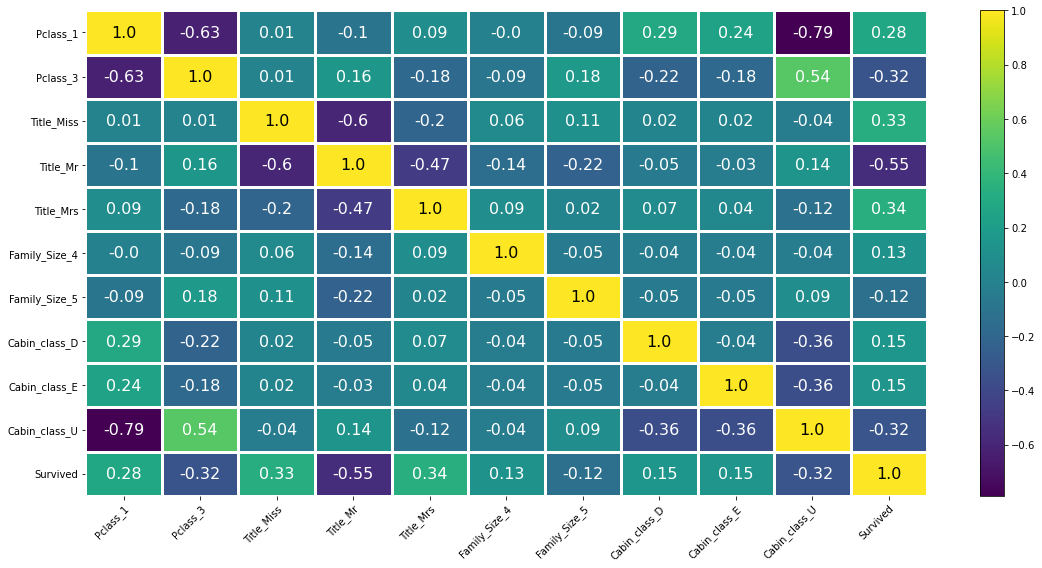

In [132]:
# Plot the correlation of the features where the correlation with the Survived feature is greater than 0.2
hm_train_new = pd.concat([X_train, y_train], axis=1).corr()
hm_Survived = hm_train_new[abs(hm_train_new['Survived']) > 0.1]
hm_Survived = hm_Survived[hm_Survived.index.tolist()]
create_heatmap(hm_Survived)

<a id='4.0'></a>
<div class="alert alert-block alert-danger">
   <h2>
    Create A Neural Network
    </h2>
</div>

<div class="alert alert-block alert-success">
    <h4>
        Model Training Graph
    </h4>
</div>

In [133]:
def model_graphs(history):
    # Set up the matplotlib figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    #############################
    ### True Negative ###

    p1, = axes[0, 0].plot(history.history['true_negatives'], 'r-', linewidth=2, label='Train')
    axes[0, 0].set_title('True Positive', color='c', size=16)
    tkw = dict(size=4, width=1.5)
    axes[0, 0].legend(handles=[p1], loc='lower right')
    # #############################
    # ### True Positive ###

    p1, = axes[0, 1].plot(history.history['true_positives'], 'r-', linewidth=2, label='Train')

    axes[0, 1].legend(loc='lower right')
    axes[0, 1].set_title('True Negative', color='c', size=16)
    axes[0, 1].yaxis.label.set_color(p1.get_color())
    tkw = dict(size=4, width=1.5)
    axes[0, 1].legend(handles=[p1], loc='lower right')
    # #############################
    # ### Accuracy ###

    axes[1, 0].plot(history.history['accuracy'], 'r-', linewidth=2, label='Train')
    axes[1, 0].legend(loc='lower right')
    axes[1, 0].set_title('Accuracy', color='c', size=16)
    # #############################
    # ### Loss ###

    axes[1, 1].plot(history.history['loss'], 'r-', linewidth=2, label='Train')
    axes[1, 1].legend(loc='lower right')
    axes[1, 1].set_title('Loss', color='c', size=16)

    #############################
    fig.tight_layout()
    fig.show()

<div class="alert alert-block alert-success">
    <h4>
        Confusion matrix and metrics
    </h4>
</div>

In [134]:
import math

def confusion_matrix_metrics(TP, FP, FN, TN):
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = round(TP / (TP + FN), 2)
    # Specificity, selectivity or true negative rate (TNR)
    TNR = round(TN / (TN + FP), 2)

    # accuracy (ACC)
    ACC = round((TP + TN) / (TP + TN + FP + FN), 2)
    # balanced accuracy (BA)
    BA = round((TPR + TNR) / 2, 2)

    # Precision or positive predictive value
    PPV = round(TP / (TP + FP), 2)
    # negative predictive value (NPV)
    NPV = round(TN / (TN + FN), 2)
    # false discovery rate (FDR)
    FDR = round(1 - PPV, 2)
    # false omission rate (FOR)
    FOR = round(1 - NPV, 2)

    # prevalence threshold (PT)
    PT = round((math.sqrt(TPR*(1 - TNR)) + TNR - 1)/(TPR + TNR - 1), 2)
    # F1 score
    F1 = round(2*TP / (2*TP + FP + FN), 2)
    # Matthews correlation coefficient (MCC) or phi coefficient
    MCC = round(((TP*TN) - (FP*FN)) / math.sqrt((TP + FP)*(TP + FN)*(TN + FP)*(TN + FN)), 2)

    # False positive rate or False alarm rate
    FPR = round(FP / (FP + TN), 2)
    # False negative rate or Miss Rate
    FNR = round(FN / (FN + TP), 2)
    
    return TPR, TNR, ACC, BA, PPV, NPV, FDR, FOR, PT, F1, MCC, FPR, FNR

In [135]:
def TP_FP_TN_FN_func(cm, dataframe):
    df_cm = pd.DataFrame(cm)
    TP = []
    FN = []
    TN = []
    FP = []
    for i in range(len(df_cm)):
        for j in range(len(df_cm.columns)):
            if i == j:
                # TP
                TP.append(df_cm.iloc[i,j])
                # FN
                df_FN = df_cm.drop(i, axis=0)
                FN_list = [row for row in range(len(df_cm)) if row != i]
                df_FN = df_FN.drop(FN_list, axis=1)
                FN.append(df_FN.sum().sum())
                # TN
                df_TN = df_cm.drop(i, axis=1)
                df_TN = df_TN.drop(i, axis=0)
                TN.append(df_TN.sum().sum())
                # FP
                df_FP = df_cm.drop(i, axis=1)
                FP_list = [row for row in range(len(df_cm)) if row != i]
                df_FP = df_FP.drop(FP_list, axis=0)
                FP.append(df_FP.sum().sum())
                
    metrics_list = []
    for i in range(len(TP)):
        # get the metric values from the confusion_matrix_metrics function
        (TPR, TNR, ACC, BA, PPV, NPV, FDR, FOR, PT, 
         F1, MCC, FPR, FNR) = confusion_matrix_metrics(TP[i], FP[i], FN[i], TN[i])
        metrics_list.append([TPR, TNR, ACC, BA, PPV, NPV, FDR, FOR, PT, F1, MCC, FPR, FNR])
    metrics_cols = ['True Positive Rate', 'True Negative Rate', 'Accuracy', 'Balanced Accuracy', 'Precision', 
                  'Negative Predictive Value', 'False Discovery Rate', 'False Omission Rate', 
                  'Prevalence Threshold', 'F1 Score', 'Matthews Correlation Coefficient', 
                  'False positive rate', 'False Negative Rate']
    
    # create a dataframe with multi-column
    l=[(dataframe, '0'),  (dataframe, '1')]
    df_cm_metrics = pd.DataFrame(metrics_list, columns=metrics_cols, index=l).T
    df_cm_metrics.columns = pd.MultiIndex.from_tuples(df_cm_metrics.columns, names=['Dataset','Metrics'])
    
    return df_cm_metrics

In [136]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_func(model, X_train, y_train, threshold, model_name):
    
    y_pred_num = model.predict(X_train)
    y_pred = [1 if j>threshold else 0 for j in y_pred_num]

    cm = confusion_matrix(y_train, y_pred).T

    #############################
    # Set up the matplotlib figure
    fig, axes = plt.subplots(figsize=(4, 4))

    # Plot the heatmap
    im = axes.imshow(cm, interpolation='nearest', cmap='Reds', aspect='auto')
    # show all ticks
    axes.set_xticks(np.arange(len(cm.tolist())))
    axes.set_yticks(np.arange(len(cm.tolist())))
    thresh = cm.max() / 1.5
    # Loop over data dimensions and create text annotations.
    for i in range(len(cm.tolist())):
        for j in range(len(cm.tolist())):
            text = axes.text(j, i, cm.tolist()[i][j],
                           ha="center", va="center", size=16,
                           color="white" if cm[i, j] > thresh else "black")
    # Let the horizontal axes labeling appear on top.
    axes.xaxis.set_ticks_position('top')
    axes.xaxis.set_label_position('top')
    axes.set_xlabel('Actual value', size=16)
    axes.set_ylabel('Predicted value', size=16)
    axes.set_title("Train", fontsize=20)

    fig.tight_layout()
    fig.show()
    
    # get the metric values as a dataframe
    df_cm_metrics = TP_FP_TN_FN_func(cm, f"{model_name}_Train")
    
    return df_cm_metrics

<a id='4.1'></a>
<div class="alert alert-block alert-info">
   <h3>
        Building Artificial Neural Network (ANN)
   </h3>
</div>

<img src="https://www.mdpi.com/genes/genes-10-00553/article_deploy/html/images/genes-10-00553-g001.png" style="height:350px">

In [137]:
X_train.shape

(890, 16)

In [138]:
import tensorflow as tf
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Dense, Dropout

model_ann = Sequential()
# total column number(X_train.shape[1] = 16) for input layer
model_ann.add(Dense(64, input_shape=(X_train.shape[1],), activation="relu"))
model_ann.add(Dense(128, activation="relu"))
model_ann.add(Dense(256, activation="relu"))
model_ann.add(Dense(128, activation="relu"))
model_ann.add(Dense(64, activation="relu"))
model_ann.add(Dense(32, activation="relu"))
model_ann.add(Dense(16, activation="relu"))

# dependent variable has only 0 and 1. Therefore, sigmoid used
model_ann.add(Dense(1, activation="sigmoid"))   # output layer

Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1


2021-08-12 14:24:50.099324: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-08-12 14:24:50.099412: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [139]:
model_ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1088      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                5

In [140]:
%%time
model_ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                  metrics = ['accuracy', 'TrueNegatives', 'TruePositives'])

history_ann = model_ann.fit(X_train, y_train, batch_size=64, epochs=100)

Epoch 1/100


2021-08-12 14:24:50.185185: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-12 14:24:50.185376: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 1/14 [=>............................] - ETA: 5s - loss: 0.6942 - accuracy: 0.5000 - true_negatives: 18.0000 - true_positives: 14.0000

2021-08-12 14:24:50.431193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 12ms/step - loss: 0.6031 - accuracy: 0.7404 - true_negatives: 518.0000 - true_positives: 141.0000
Epoch 2/100
14/14 [==============================] - 0s 9ms/step - loss: 0.4453 - accuracy: 0.8146 - true_negatives: 487.0000 - true_positives: 238.0000
Epoch 3/100
14/14 [==============================] - 0s 9ms/step - loss: 0.4171 - accuracy: 0.8281 - true_negatives: 491.0000 - true_positives: 246.0000
Epoch 4/100
14/14 [==============================] - 0s 9ms/step - loss: 0.3958 - accuracy: 0.8371 - true_negatives: 497.0000 - true_positives: 248.0000
Epoch 5/100
14/14 [==============================] - 0s 9ms/step - loss: 0.3947 - accuracy: 0.8483 - true_negatives: 487.0000 - true_positives: 268.0000
Epoch 6/100
14/14 [==============================] - 0s 9ms/step - loss: 0.3803 - accuracy: 0.8506 - true_negatives: 502.0000 - true_positives: 255.0000
Epoch 7/100
14/14 [==============================] - 0s 9ms/step - loss: 0.3662 - accuracy: 0

In [141]:
# List all data in history
history_ann.history.keys()

dict_keys(['loss', 'accuracy', 'true_negatives', 'true_positives'])

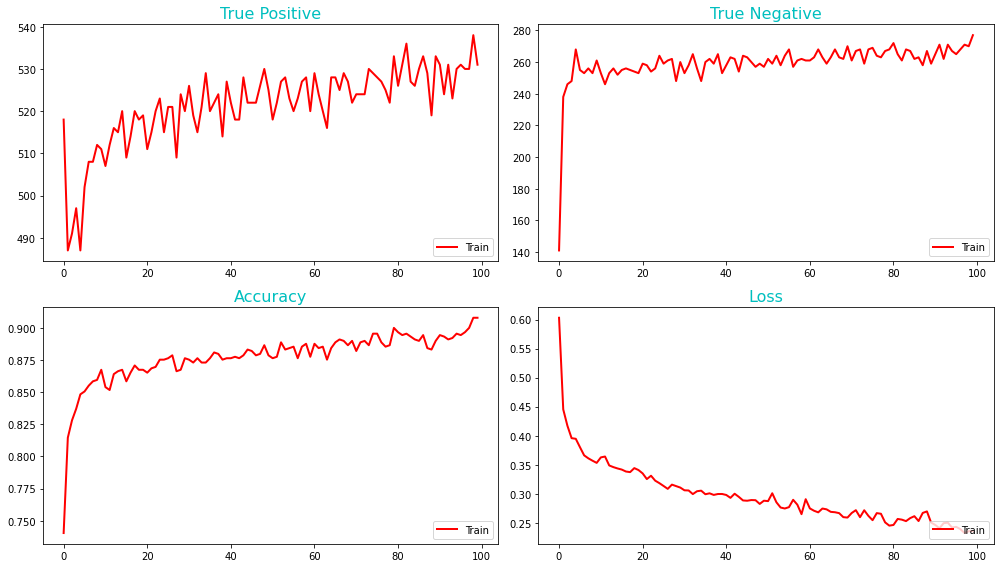

In [142]:
model_graphs(history_ann)

2021-08-12 14:25:04.091957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


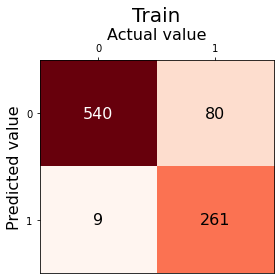

In [143]:
df_cm_metrics_ann = confusion_matrix_func(model_ann, X_train, y_train, threshold=0.50, 
                                          model_name='ANN')

<a id='4.2'></a>
<div class="alert alert-block alert-info">
   <h3>
        Building Convolutional Neural Network (CNN)
   </h3>
</div>

<img src="https://miro.medium.com/max/2000/1*hYN6b13CKaTN1jnafkq5KQ.jpeg" style="height:350px">

In [144]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Dropout, 
                                     BatchNormalization, UpSampling2D)
import pandas as pd
import numpy as np

model_cnn = Sequential()
model_cnn.add(Dense(128 * 2 * 2, activation="relu", input_dim=X_train.shape[1],))
model_cnn.add(Reshape((2, 2, 128)))
model_cnn.add(BatchNormalization(momentum=0.8))
model_cnn.add(UpSampling2D())
model_cnn.add(Conv2D(128, kernel_size=3, padding="same", activation ='relu'))
model_cnn.add(BatchNormalization(momentum=0.8))
model_cnn.add(UpSampling2D())
model_cnn.add(Conv2D(64, kernel_size=3, padding="same", activation ='relu'))
model_cnn.add(BatchNormalization(momentum=0.8))
model_cnn.add(UpSampling2D())
model_cnn.add(Conv2D(32, kernel_size=3, padding="same", activation ='relu'))
model_cnn.add(BatchNormalization(momentum=0.8))
model_cnn.add(UpSampling2D())
# model_cnn.add(MaxPooling2D(pool_size = (1,6), strides=(1,2)))
model_cnn.add(Flatten())
model_cnn.add(Dense (256, activation='relu'))
# model_cnn.add(Dropout(0.2))
model_cnn.add(Dense (128, activation='relu'))
model_cnn.add(Dense (64, activation='relu'))
model_cnn.add(Dense (32, activation='relu'))
model_cnn.add(Dense (1, activation='sigmoid'))
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               8704      
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 2, 128)         512       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 4, 128)         147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 128)        

In [145]:
model_cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                  metrics = ['accuracy', 'TrueNegatives', 'TruePositives'])

history_cnn = model_cnn.fit(X_train, y_train, batch_size=64, epochs=100)

Epoch 1/100


2021-08-12 14:25:04.615430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 56ms/step - loss: 0.6762 - accuracy: 0.7281 - true_negatives: 440.0000 - true_positives: 208.0000
Epoch 2/100
14/14 [==============================] - 1s 45ms/step - loss: 0.4940 - accuracy: 0.8067 - true_negatives: 489.0000 - true_positives: 229.0000
Epoch 3/100
14/14 [==============================] - 1s 41ms/step - loss: 0.4591 - accuracy: 0.8079 - true_negatives: 481.0000 - true_positives: 238.0000
Epoch 4/100
14/14 [==============================] - 1s 42ms/step - loss: 0.4222 - accuracy: 0.8371 - true_negatives: 500.0000 - true_positives: 245.0000
Epoch 5/100
14/14 [==============================] - 1s 43ms/step - loss: 0.4062 - accuracy: 0.8404 - true_negatives: 503.0000 - true_positives: 245.0000
Epoch 6/100
14/14 [==============================] - 1s 42ms/step - loss: 0.3581 - accuracy: 0.8494 - true_negatives: 508.0000 - true_positives: 248.0000
Epoch 7/100
14/14 [==============================] - 1s 43ms/step - loss: 0.3957 - accur

Epoch 54/100
14/14 [==============================] - 1s 42ms/step - loss: 0.3127 - accuracy: 0.8753 - true_negatives: 523.0000 - true_positives: 256.0000
Epoch 55/100
14/14 [==============================] - 1s 40ms/step - loss: 0.3026 - accuracy: 0.8730 - true_negatives: 519.0000 - true_positives: 258.0000
Epoch 56/100
14/14 [==============================] - 1s 40ms/step - loss: 0.3047 - accuracy: 0.8820 - true_negatives: 526.0000 - true_positives: 259.0000
Epoch 57/100
14/14 [==============================] - 1s 44ms/step - loss: 0.3073 - accuracy: 0.8775 - true_negatives: 527.0000 - true_positives: 254.0000
Epoch 58/100
14/14 [==============================] - 1s 43ms/step - loss: 0.2994 - accuracy: 0.8663 - true_negatives: 520.0000 - true_positives: 251.0000
Epoch 59/100
14/14 [==============================] - 1s 42ms/step - loss: 0.2877 - accuracy: 0.8787 - true_negatives: 520.0000 - true_positives: 262.0000
Epoch 60/100
14/14 [==============================] - 1s 44ms/step - l

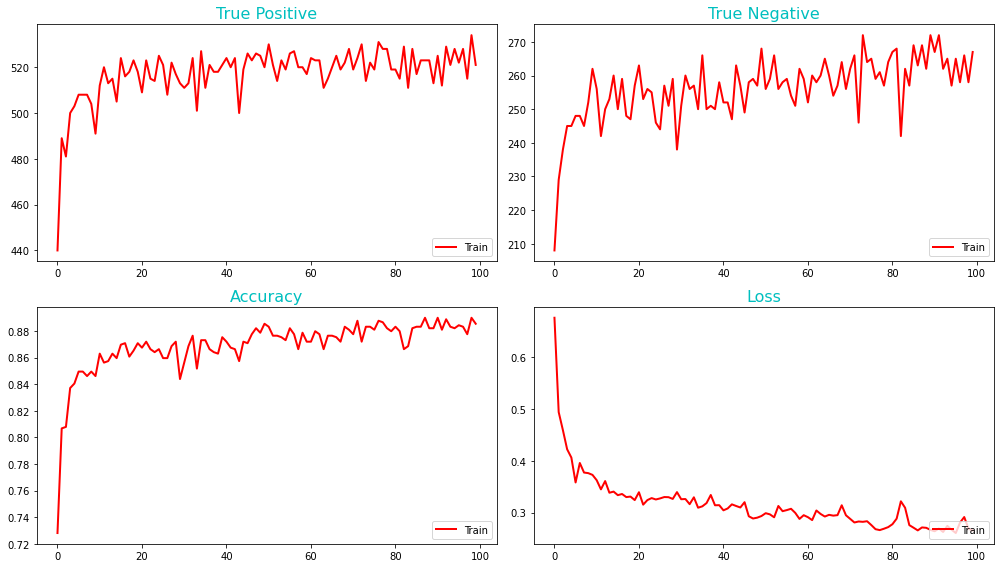

In [146]:
model_graphs(history_cnn)

2021-08-12 14:26:03.633625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


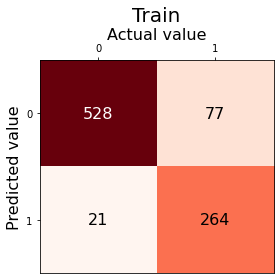

In [147]:
df_cm_metrics_cnn = confusion_matrix_func(model_cnn, X_train, y_train, threshold=0.50, 
                                          model_name='CNN')

In [148]:
pd.concat([df_cm_metrics_ann, df_cm_metrics_cnn], axis=1)

Dataset                          ANN_Train       CNN_Train      
Metrics                                  0     1         0     1
True Positive Rate                    0.98  0.77      0.96  0.77
True Negative Rate                    0.77  0.98      0.77  0.96
Accuracy                              0.90  0.90      0.89  0.89
Balanced Accuracy                     0.88  0.88      0.86  0.86
Precision                             0.87  0.97      0.87  0.93
Negative Predictive Value             0.97  0.87      0.93  0.87
False Discovery Rate                  0.13  0.03      0.13  0.07
False Omission Rate                   0.03  0.13      0.07  0.13
Prevalence Threshold                  0.33  0.14      0.33  0.19
F1 Score                              0.92  0.85      0.92  0.84
Matthews Correlation Coefficient      0.79  0.79      0.77  0.77
False positive rate                   0.23  0.02      0.23  0.04
False Negative Rate                   0.02  0.23      0.04  0.23

<a id='4.3'></a>
<div class="alert alert-block alert-info">
   <h3>
        Evaluation of the model
   </h3>
</div>

In [149]:
%%time
tpr_list = []
tnr_list = []
fpr_list = []
acc_list = []
thresholds_list = []
precision_list = []
npv_list = []

for i in range(0, 100, 1):    
    y_train_pred_num = model_cnn.predict(X_train)
    y_train_pred = [1 if j>i/100 else 0 for j in y_train_pred_num]
    cm_train = confusion_matrix(y_train, y_train_pred).T

    df_cm_train_metrics = TP_FP_TN_FN_func(cm_train, 'Train')
    TPR_train = df_cm_train_metrics.loc['True Positive Rate','Train'][0]
    TNR_train = df_cm_train_metrics.loc['True Negative Rate','Train'][0]
    FPR_train = df_cm_train_metrics.loc['False positive rate','Train'][0]
    acc_train = df_cm_train_metrics.loc['Accuracy','Train'][0]
    precision_train = df_cm_train_metrics.loc['Precision','Train'][0]
    npv_train = df_cm_train_metrics.loc['Negative Predictive Value','Train'][0]
    
    
    tpr_list.append(TPR_train)
    tnr_list.append(TNR_train)
    fpr_list.append(FPR_train)
    acc_list.append(acc_train)
    thresholds_list.append(i/100)
    precision_list.append(precision_train)
    npv_list.append(npv_train)

CPU times: user 13 s, sys: 12.1 s, total: 25 s
Wall time: 33.7 s


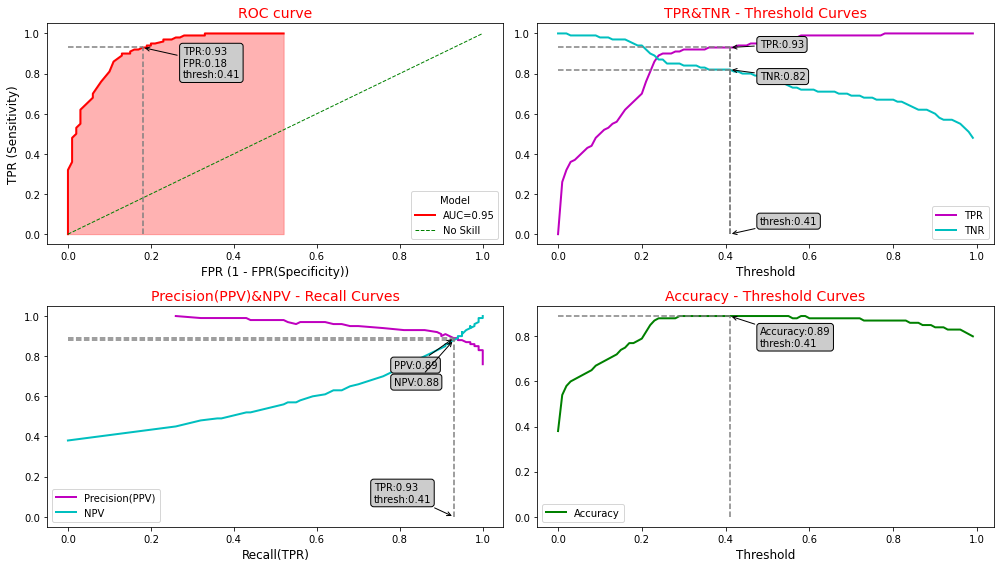

In [150]:
from sklearn.metrics import roc_auc_score

threshold=0.40
idx = next(x[0] for x in enumerate(thresholds_list) if x[1] > threshold)

# compute Area Under the Receiver Operating Characteristic Curve (ROC AUC)
y_train_pred = model_cnn.predict(X_train)
lr_auc = roc_auc_score(y_train, y_train_pred)

#############################
# Set up the matplotlib figure
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
#############################
### ROC Curve ###

axes[0, 0].plot(fpr_list, tpr_list, color='red', linewidth=2, 
                label=f'AUC={lr_auc:.2f}')
axes[0, 0].fill_between(fpr_list, tpr_list, 0, color='red', alpha=0.3)
axes[0, 0].plot([0, 1], [0, 1], color='green', linestyle='--', linewidth=1,
                label='No Skill')

axes[0, 0].set_xlabel('FPR (1 - FPR(Specificity))', size=12)
axes[0, 0].set_ylabel('TPR (Sensitivity)', size=12)
axes[0, 0].legend(title='Model')
axes[0, 0].set_title('ROC curve', color='red', size=14)

# Annotate #
axes[0, 0].plot([0,fpr_list[idx]], [tpr_list[idx],tpr_list[idx]], 'k--', color='gray')
axes[0, 0].plot([fpr_list[idx],fpr_list[idx]], [0,tpr_list[idx]], 'k--', color='gray')
axes[0, 0].annotate(
    f'TPR:{tpr_list[idx]:.2f}\nFPR:{fpr_list[idx]:.2f}\nthresh:{thresholds_list[idx]:.2f}',
    (fpr_list[idx], tpr_list[idx]), xytext =(-2 * -20, -30), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
#############################

#############################
### TPR and FPR at every threshold ###

axes[0, 1].plot(thresholds_list, tpr_list, color='m', linewidth=2, label='TPR')
axes[0, 1].plot(thresholds_list, tnr_list, color='c', linewidth=2, label='TNR')
axes[0, 1].set_xlabel('Threshold', size=12)
axes[0, 1].legend()
axes[0, 1].set_title('TPR&TNR - Threshold Curves', color='red', size=14)

axes[0, 1].plot([thresholds_list[idx],thresholds_list[idx]], [0,tpr_list[idx]], 'k--', color='gray')


# Annotate #
axes[0, 1].plot([thresholds_list[idx],thresholds_list[idx]], [0,tpr_list[idx]], 'k--', color='gray')
axes[0, 1].plot([0, thresholds_list[idx]], [tpr_list[idx] ,tpr_list[idx]], 'k--', color='gray')
axes[0, 1].plot([0, thresholds_list[idx]], [tnr_list[idx] ,tnr_list[idx]], 'k--', color='gray')

axes[0, 1].annotate(
    f'TPR:{tpr_list[idx]:.2f}',
    (thresholds_list[idx], tpr_list[idx]), xytext =(-2 * -15, 0), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))

axes[0, 1].annotate(
    f'TNR:{tnr_list[idx]:.2f}',
    (thresholds_list[idx], tnr_list[idx]), xytext =(-2 * -15, -10), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))

axes[0, 1].annotate(f'thresh:{thresholds_list[idx]:.2f}',
    (thresholds_list[idx], 0), xytext =(-2 * -15, 10), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
#############################

#############################
### Precision-Recall Curve ###

axes[1, 0].plot(tpr_list, precision_list, color='m', linewidth=2, label='Precision(PPV)')
axes[1, 0].plot(tpr_list, npv_list, color='c', linewidth=2, label='NPV')

axes[1, 0].set_xlabel('Recall(TPR)', size=12)
axes[1, 0].legend()
axes[1, 0].set_title('Precision(PPV)&NPV - Recall Curves', color='red', size=14)

# Annotate
axes[1, 0].plot([tpr_list[idx],tpr_list[idx]], [0,precision_list[idx]], 'k--', color='gray')
axes[1, 0].plot([0, tpr_list[idx]], [precision_list[idx] ,precision_list[idx]], 'k--', color='gray')
axes[1, 0].plot([0, tpr_list[idx]], [npv_list[idx] ,npv_list[idx]], 'k--', color='gray')

axes[1, 0].annotate(f'PPV:{precision_list[idx]:.2f}',
    (tpr_list[idx], precision_list[idx]), xytext =(-2 * 30, -30), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
axes[1, 0].annotate(f'NPV:{npv_list[idx]:.2f}',
    (tpr_list[idx], npv_list[idx]), xytext =(-2 * 30, -45), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
axes[1, 0].annotate(f'TPR:{tpr_list[idx]:.2f}\nthresh:{thresholds_list[idx]:.2f}',
    (tpr_list[idx], 0), xytext =(-2 * 40, 15), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
#############################

#############################
### Accuracy at every threshold ###

axes[1, 1].plot(thresholds_list, acc_list, color='g', linewidth=2, label='Accuracy')
axes[1, 1].set_xlabel('Threshold', size=12)
axes[1, 1].legend()
axes[1, 1].set_title('Accuracy - Threshold Curves', color='red', size=14)

# Annotate #
axes[1, 1].plot([thresholds_list[idx],thresholds_list[idx]], [0,acc_list[idx]], 'k--', color='gray')
axes[1, 1].plot([0, thresholds_list[idx]], [acc_list[idx] ,acc_list[idx]], 'k--', color='gray')

axes[1, 1].annotate(
    f'Accuracy:{acc_list[idx]:.2f}\nthresh:{thresholds_list[idx]:.2f}',
    (thresholds_list[idx], acc_list[idx]), xytext =(-2 * -15, -30), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))

#############################
fig.tight_layout()
fig.show()

<div class="alert alert-block alert-success">
    <h4>
        Final Confusion Matrix
    </h4>
</div>

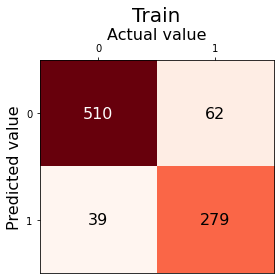

In [151]:
df_cm_metrics_cnn = confusion_matrix_func(model_cnn, X_train, y_train, threshold=0.40, 
                                          model_name='CNN')

<a id='5.0'></a>
<div class="alert alert-block alert-danger">
<h2>Submission</h2>
</div>

In [152]:
submission = gender_submission.drop('Survived', axis=1)


threshold=0.7
y_train_pred_num = model_ann.predict(X_test)
y_pred_kaggle = [1 if j>threshold else 0 for j in y_train_pred_num]

submission['Survived'] = y_pred_kaggle
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [153]:
# submission = gender_submission.drop('Survived', axis=1)
# y_pred_kaggle = model.predict(X_test)
# submission['Survived'] = y_pred_kaggle
# submission.head()

In [154]:
# Are our test and submission dataframes the same length?
if len(submission) == len(gender_submission):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [155]:
# Convert submisison dataframe to csv for submission to csv for Kaggle submisison
file_name = 'titanic_submission_kaggle_cnn.csv'
submission.to_csv(file_name, index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [156]:
# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv(file_name)
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


<a id='5.1'></a>
<div class="alert alert-block alert-info">
   <h3>
        Results on the Kaggle website
   </h3>
</div>

<ul>
    
<li>Threshold = 0.40<br>
cnn -> 0.73923 </li>
<li>Threshold = 0.50<br>
cnn -> 0.74641 </li>
<li>Threshold = 0.60<br>
cnn -> 0.75358 </li>
<li>Threshold = 0.65<br>
cnn -> 0.76794 </li>

<li><span style="color:red"><strong>
Threshold = 0.70<br>
cnn -> 0.77033 <br>
ann -> 0.76555 <br>
</strong></span></li>

<li>Threshold = 0.75<br>
cnn -> 0.75837 </li>
<li>Threshold = 0.80<br>
cnn -> 0.75837 </li>
    
</ul>